## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Distortion Correction Parameter

In [2]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [3]:
# plot the original images and corrected images

for imgName in images:
    img = cv2.imread(imgName)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    undistorted = cv2.undistort(gray, mtx, dist, None, mtx)
    tmp = np.vstack((gray, undistorted))
    cv2.imshow('img', tmp)
    cv2.waitKey(500)
cv2.destroyAllWindows()

In [4]:
%matplotlib inline 
# test on stright line images 
test_images = glob.glob('./test_images/*.jpg')
img = cv2.imread(test_images[4])
undist = cv2.undistort(img, mtx, dist, None, mtx)
# f, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
# ax1.imshow(img)
# ax2.imshow(undist)
cv2.imshow('img1', img)
cv2.imshow('undist', undist)

## gradient && threshold

In [5]:
## different kinds of gradient and threshold
def xDirGradThreshold(img, sobel_kernel=3, thresh = (0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    binary_output = np.zeros_like(sobelx)
    binary_output[(sobelx >= thresh[0])& (sobelx <= thresh[1])] = 1
    return binary_output
    
def yDirGradThreshold(img, sobel_kernel=3, thresh = (0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    binary_output = np.zeros_like(sobely)
    binary_output[(sobely >= thresh[0])&(sobely <= thresh[1])] = 1
    return binary_output

def magGradThreshold(img, sobel_kernel=3, thresh = (0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    sobelMag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobelMag = np.uint8(255*sobelMag/np.max(sobelMag))
    
    binary_output = np.zeros_like(scaled_sobelMag)
    binary_output[(scaled_sobelMag > thresh[0])&(scaled_sobelMag < thresh[1])] = 1
    return binary_output

def dirGradThreshold(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dirGrd = np.arctan2(abs_sobely, abs_sobelx)

    binary_output = np.zeros_like(dirGrd)
    binary_output[(dirGrd > thresh[0])&(dirGrd < thresh[1])] = 1
    return binary_output

def hlsGradThreshold(img, sobel_kernel=3, thresh=(100,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S < thresh[1])] = 1
    return binary_output

def absoluteGradThreshold(img, orientation='x', sobel_kernel=3, thresh=(0,255)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if orientation == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    elif orientation == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    else:
        return 'wrong direction'

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel) 
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    return binary_output
    

In [6]:
#combination of gradient thresh
def combinationGD(img, ksize):
    img = cv2.GaussianBlur(img, (5, 5), 0)
    binary_mag = magGradThreshold(img, ksize, (40,255))
    binary_hls = hlsGradThreshold(img, ksize, (160,255))
    binary_dir = dirGradThreshold(img, ksize, (0.65,1.05))
    binary_xAbs = absoluteGradThreshold(img, 'x', ksize, (10,255))
    binary_yAbs = absoluteGradThreshold(img, 'y', ksize, (60,255))
    binary_comb = np.zeros_like(binary_mag)
    
    binary_comb[((binary_mag==1) & (binary_dir==1))|((binary_yAbs==1)&(binary_xAbs==1))|(binary_hls==1)] = 1
    
    return binary_comb

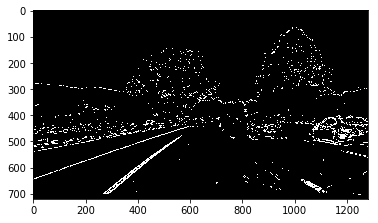

In [7]:
#perspective transf

img = cv2.imread(test_images[4])

undistorted = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imshow('img',undistorted)

binaryComb = combinationGD(undistorted,7)
plt.imshow(binaryComb, cmap='gray')


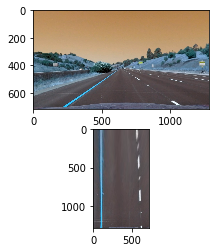

In [8]:
#perspective transf
nx = 1280
ny = 720

img = cv2.imread(test_images[0])
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
plt.subplot(211)
plt.imshow(undistorted, cmap='gray')
cv2.imshow('original', undistorted)
xOffset = 20
yOffset = 20
src = np.float32([[580,450],[710,450],[1200,700],[100,700]])
dst = np.float32([[xOffset,yOffset],[ny-xOffset,yOffset],[ny-xOffset, nx],[xOffset,nx]])
# dst = np.float32([[0,0],[ny,0],[ny, nx],[0,nx]])

M    = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undistorted, M, (img.shape[0], img.shape[1]), flags=cv2.INTER_LINEAR)
plt.subplot(212)
plt.imshow(warped, cmap='gray')
cv2.imshow('perspective', warped)

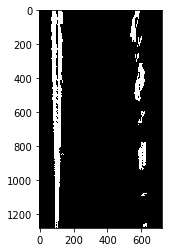

In [9]:
#perspective transf

img = cv2.imread(test_images[0])
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
binaryComb = combinationGD(undistorted,7)
# plt.subplot(121)
# plt.imshow(undistorted)

warped = cv2.warpPerspective(binaryComb, M, (img.shape[0], img.shape[1]), flags=cv2.INTER_LINEAR)
# plt.subplot(122)
# %matplotlib qt
plt.imshow(warped, cmap='gray')


In [10]:
laneWidthPix  = 503.0
laneWidthM    = 3.7
laneLengthPix = 185.0
laneLengthM   = 3.0
xm_per_pix = laneWidthM / laneWidthPix
ym_per_pix = laneLengthM / laneLengthPix

In [11]:
#sliding windows
def laneCenterExample(binary_warped, nwindows=10, margin = 100, minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    halfImg = np.int(binary_warped.shape[0]/2)
    histogram = np.sum(binary_warped[halfImg:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print (rightx_base - leftx_base)
    # Choose the number of sliding windows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        print (win_y_low, win_y_high, win_xleft_low, win_xleft_high)
        print (win_y_low, win_y_high, win_xright_low, win_xright_high)
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 10) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 10) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 720)
    plt.ylim(1280, 0)
    return  left_fitx, right_fitx, ploty


In [12]:
# lane extraction
def laneExtraction(binary_warped, nwindows=10, margin = 100, minpix = 50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    halfImg = np.int(binary_warped.shape[0]/2)
    histogram = np.sum(binary_warped[halfImg:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print (rightx_base - leftx_base)
    # Choose the number of sliding windows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_fitM  = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fitM = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    curvature = ((1 + (2*left_fitM[0]*np.max(ploty) + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    center = (left_fitx[-1] + right_fitx[-1])/2
    position = (ny/2 - center) * xm_per_pix

    return left_fit, left_fitx, right_fit, right_fitx, ploty, curvature, position


In [13]:
# draw lane marking process
def drawLine(undist, binary_warped, left_fitx, right_fitx, ploty, curvature, position):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result,text,(400,100), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    
    text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(400,150), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2)
    return result


In [14]:
left_fit, left_fitx, right_fit, right_fitx, ploty, curvature, position=laneExtraction(warped)
result = drawLine(undist, warped, left_fitx,right_fitx, ploty, curvature, position)
cv2.imshow('example',result)

503


In [15]:
#whole process of lane detection
# 
# Step 1: distortion correction;
# Step 2: color&gradient threshold;
# Step 3: perspective transform;
# Step 4: sliding windows
# Step 5: return to image
ksize = 7
def process_image(img):
    #step1
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    #step2
    binaryComb = combinationGD(undistorted, ksize)
    #step3
    binary_warped = cv2.warpPerspective(binaryComb, M, (img.shape[0], img.shape[1]), flags=cv2.INTER_LINEAR)
    #step4
    left_fit, left_fitx, right_fit, right_fitx, ploty, curvature, position = laneExtraction(binary_warped)
    #step5
    result = drawLine(undistorted, binary_warped, left_fitx, right_fitx, ploty, curvature, position)
#     plt.imshow(result)
    
    return result


In [16]:
img = cv2.imread(test_images[0])
cv2.imshow('img',img)
result = process_image(img)
cv2.imshow('final',result)

503


In [17]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_laneDetection.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

514
[MoviePy] >>>> Building video project_laneDetection.mp4
[MoviePy] Writing video project_laneDetection.mp4


  0%|          | 1/1261 [00:00<05:21,  3.92it/s]

514


  0%|          | 2/1261 [00:00<05:18,  3.95it/s]

517


  0%|          | 3/1261 [00:00<05:08,  4.08it/s]

521


  0%|          | 4/1261 [00:00<05:01,  4.18it/s]

483


  0%|          | 5/1261 [00:01<04:55,  4.25it/s]

489


  0%|          | 6/1261 [00:01<04:46,  4.38it/s]

489


  1%|          | 7/1261 [00:01<04:46,  4.38it/s]

495


  1%|          | 8/1261 [00:01<04:44,  4.40it/s]

481


  1%|          | 9/1261 [00:02<04:44,  4.40it/s]

488


  1%|          | 10/1261 [00:02<04:43,  4.42it/s]

506


  1%|          | 11/1261 [00:02<04:42,  4.42it/s]

509


  1%|          | 12/1261 [00:02<04:49,  4.31it/s]

519


  1%|          | 13/1261 [00:03<04:54,  4.24it/s]

522


  1%|          | 14/1261 [00:03<05:04,  4.10it/s]

519


  1%|          | 15/1261 [00:03<04:57,  4.18it/s]

515


  1%|▏         | 16/1261 [00:03<04:55,  4.21it/s]

445


  1%|▏         | 17/1261 [00:03<05:03,  4.10it/s]

458


  1%|▏         | 18/1261 [00:04<04:56,  4.19it/s]

453


  2%|▏         | 19/1261 [00:04<04:57,  4.17it/s]

475


  2%|▏         | 20/1261 [00:04<04:52,  4.24it/s]

484


  2%|▏         | 21/1261 [00:04<04:43,  4.37it/s]

492


  2%|▏         | 22/1261 [00:05<04:38,  4.44it/s]

523


  2%|▏         | 23/1261 [00:05<04:32,  4.54it/s]

515


  2%|▏         | 24/1261 [00:05<04:28,  4.60it/s]

529


  2%|▏         | 25/1261 [00:05<04:32,  4.53it/s]

524


  2%|▏         | 26/1261 [00:05<04:27,  4.62it/s]

536


  2%|▏         | 27/1261 [00:06<04:30,  4.56it/s]

542


  2%|▏         | 28/1261 [00:06<04:27,  4.61it/s]

535


  2%|▏         | 29/1261 [00:06<04:26,  4.62it/s]

532


  2%|▏         | 30/1261 [00:06<04:25,  4.63it/s]

476


  2%|▏         | 31/1261 [00:07<04:31,  4.53it/s]

496


  3%|▎         | 32/1261 [00:07<04:36,  4.44it/s]

481


  3%|▎         | 33/1261 [00:07<04:40,  4.38it/s]

489


  3%|▎         | 34/1261 [00:07<04:31,  4.52it/s]

508


  3%|▎         | 35/1261 [00:08<04:46,  4.28it/s]

512


  3%|▎         | 36/1261 [00:08<04:44,  4.31it/s]

514


  3%|▎         | 37/1261 [00:08<04:49,  4.23it/s]

517


  3%|▎         | 38/1261 [00:08<04:41,  4.35it/s]

513


  3%|▎         | 39/1261 [00:08<04:38,  4.39it/s]

516


  3%|▎         | 40/1261 [00:09<04:50,  4.20it/s]

516


  3%|▎         | 41/1261 [00:09<04:55,  4.13it/s]

452


  3%|▎         | 42/1261 [00:09<04:44,  4.28it/s]

452


  3%|▎         | 43/1261 [00:09<05:04,  3.99it/s]

472


  3%|▎         | 44/1261 [00:10<04:55,  4.12it/s]

478


  4%|▎         | 45/1261 [00:10<04:43,  4.29it/s]

478


  4%|▎         | 46/1261 [00:10<04:43,  4.29it/s]

494


  4%|▎         | 47/1261 [00:10<04:36,  4.39it/s]

503


  4%|▍         | 48/1261 [00:11<04:35,  4.41it/s]

494


  4%|▍         | 49/1261 [00:11<04:36,  4.39it/s]

514


  4%|▍         | 50/1261 [00:11<04:35,  4.40it/s]

512


  4%|▍         | 51/1261 [00:11<04:32,  4.44it/s]

520


  4%|▍         | 52/1261 [00:11<04:36,  4.37it/s]

517


  4%|▍         | 53/1261 [00:12<04:39,  4.32it/s]

515


  4%|▍         | 54/1261 [00:12<04:37,  4.35it/s]

453


  4%|▍         | 55/1261 [00:12<04:41,  4.29it/s]

461


  4%|▍         | 56/1261 [00:12<04:45,  4.22it/s]

469


  5%|▍         | 57/1261 [00:13<04:43,  4.25it/s]

469


  5%|▍         | 58/1261 [00:13<04:41,  4.28it/s]

505


  5%|▍         | 59/1261 [00:13<04:44,  4.23it/s]

494


  5%|▍         | 60/1261 [00:13<04:45,  4.20it/s]

486


  5%|▍         | 61/1261 [00:14<04:40,  4.28it/s]

500


  5%|▍         | 62/1261 [00:14<04:47,  4.17it/s]

501


  5%|▍         | 63/1261 [00:14<04:51,  4.11it/s]

512


  5%|▌         | 64/1261 [00:14<04:54,  4.06it/s]

506


  5%|▌         | 65/1261 [00:15<04:46,  4.18it/s]

447


  5%|▌         | 66/1261 [00:15<04:51,  4.10it/s]

438


  5%|▌         | 67/1261 [00:15<04:46,  4.17it/s]

446


  5%|▌         | 68/1261 [00:15<04:48,  4.13it/s]

455


  5%|▌         | 69/1261 [00:16<04:43,  4.20it/s]

460


  6%|▌         | 70/1261 [00:16<04:42,  4.21it/s]

481


  6%|▌         | 71/1261 [00:16<04:44,  4.18it/s]

473


  6%|▌         | 72/1261 [00:16<04:39,  4.25it/s]

496


  6%|▌         | 73/1261 [00:16<04:40,  4.24it/s]

482


  6%|▌         | 74/1261 [00:17<04:41,  4.21it/s]

487


  6%|▌         | 75/1261 [00:17<04:41,  4.22it/s]

494


  6%|▌         | 76/1261 [00:17<04:47,  4.12it/s]

497


  6%|▌         | 77/1261 [00:17<04:51,  4.05it/s]

513


  6%|▌         | 78/1261 [00:18<04:52,  4.05it/s]

513


  6%|▋         | 79/1261 [00:18<04:45,  4.14it/s]

519


  6%|▋         | 80/1261 [00:18<04:41,  4.19it/s]

500


  6%|▋         | 81/1261 [00:18<04:41,  4.18it/s]

504


  7%|▋         | 82/1261 [00:19<04:44,  4.14it/s]

490


  7%|▋         | 83/1261 [00:19<04:48,  4.09it/s]

515


  7%|▋         | 84/1261 [00:19<04:37,  4.24it/s]

527


  7%|▋         | 85/1261 [00:19<04:41,  4.17it/s]

528


  7%|▋         | 86/1261 [00:20<04:39,  4.20it/s]

514


  7%|▋         | 87/1261 [00:20<04:45,  4.12it/s]

504


  7%|▋         | 88/1261 [00:20<04:39,  4.19it/s]

524


  7%|▋         | 89/1261 [00:20<04:39,  4.19it/s]

519


  7%|▋         | 90/1261 [00:21<04:40,  4.17it/s]

464


  7%|▋         | 91/1261 [00:21<04:38,  4.20it/s]

461


  7%|▋         | 92/1261 [00:21<04:40,  4.17it/s]

475


  7%|▋         | 93/1261 [00:21<04:33,  4.27it/s]

469


  7%|▋         | 94/1261 [00:22<04:34,  4.25it/s]

469


  8%|▊         | 95/1261 [00:22<04:30,  4.31it/s]

491


  8%|▊         | 96/1261 [00:22<04:28,  4.35it/s]

495


  8%|▊         | 97/1261 [00:22<04:32,  4.27it/s]

500


  8%|▊         | 98/1261 [00:22<04:29,  4.31it/s]

489


  8%|▊         | 99/1261 [00:23<04:27,  4.35it/s]

492


  8%|▊         | 100/1261 [00:23<04:26,  4.35it/s]

498


  8%|▊         | 101/1261 [00:23<04:35,  4.21it/s]

499


  8%|▊         | 102/1261 [00:23<04:30,  4.28it/s]

502


  8%|▊         | 103/1261 [00:24<04:36,  4.18it/s]

509


  8%|▊         | 104/1261 [00:24<04:38,  4.16it/s]

473


  8%|▊         | 105/1261 [00:24<04:38,  4.15it/s]

482


  8%|▊         | 106/1261 [00:24<04:32,  4.24it/s]

489


  8%|▊         | 107/1261 [00:25<04:28,  4.30it/s]

498


  9%|▊         | 108/1261 [00:25<04:21,  4.42it/s]

499


  9%|▊         | 109/1261 [00:25<04:25,  4.34it/s]

504


  9%|▊         | 110/1261 [00:25<04:33,  4.21it/s]

511


  9%|▉         | 111/1261 [00:26<04:36,  4.15it/s]

513


  9%|▉         | 112/1261 [00:26<04:30,  4.25it/s]

521


  9%|▉         | 113/1261 [00:26<04:31,  4.23it/s]

521


  9%|▉         | 114/1261 [00:26<04:31,  4.22it/s]

508


  9%|▉         | 115/1261 [00:26<04:33,  4.19it/s]

518


  9%|▉         | 116/1261 [00:27<04:30,  4.24it/s]

513


  9%|▉         | 117/1261 [00:27<04:29,  4.24it/s]

477


  9%|▉         | 118/1261 [00:27<04:33,  4.18it/s]

481


  9%|▉         | 119/1261 [00:27<04:41,  4.06it/s]

469


 10%|▉         | 120/1261 [00:28<04:31,  4.21it/s]

486


 10%|▉         | 121/1261 [00:28<04:26,  4.29it/s]

494


 10%|▉         | 122/1261 [00:28<04:21,  4.36it/s]

498


 10%|▉         | 123/1261 [00:28<04:24,  4.30it/s]

501


 10%|▉         | 124/1261 [00:29<04:22,  4.34it/s]

504


 10%|▉         | 125/1261 [00:29<04:20,  4.35it/s]

507


 10%|▉         | 126/1261 [00:29<04:25,  4.27it/s]

515


 10%|█         | 127/1261 [00:29<04:25,  4.28it/s]

518


 10%|█         | 128/1261 [00:30<04:32,  4.15it/s]

522


 10%|█         | 129/1261 [00:30<04:32,  4.16it/s]

444


 10%|█         | 130/1261 [00:30<04:28,  4.22it/s]

453


 10%|█         | 131/1261 [00:30<04:22,  4.30it/s]

463


 10%|█         | 132/1261 [00:30<04:17,  4.38it/s]

460


 11%|█         | 133/1261 [00:31<04:12,  4.47it/s]

476


 11%|█         | 134/1261 [00:31<04:12,  4.45it/s]

479


 11%|█         | 135/1261 [00:31<04:15,  4.41it/s]

483


 11%|█         | 136/1261 [00:31<04:18,  4.34it/s]

490


 11%|█         | 137/1261 [00:32<04:13,  4.43it/s]

492


 11%|█         | 138/1261 [00:32<04:12,  4.45it/s]

510


 11%|█         | 139/1261 [00:32<04:18,  4.34it/s]

515


 11%|█         | 140/1261 [00:32<04:18,  4.33it/s]

520


 11%|█         | 141/1261 [00:32<04:21,  4.28it/s]

517


 11%|█▏        | 142/1261 [00:33<04:22,  4.27it/s]

456


 11%|█▏        | 143/1261 [00:33<04:18,  4.32it/s]

476


 11%|█▏        | 144/1261 [00:33<04:19,  4.30it/s]

462


 11%|█▏        | 145/1261 [00:33<04:20,  4.28it/s]

486


 12%|█▏        | 146/1261 [00:34<04:17,  4.33it/s]

490


 12%|█▏        | 147/1261 [00:34<04:14,  4.37it/s]

497


 12%|█▏        | 148/1261 [00:34<04:14,  4.38it/s]

483


 12%|█▏        | 149/1261 [00:34<04:16,  4.33it/s]

502


 12%|█▏        | 150/1261 [00:35<04:19,  4.28it/s]

508


 12%|█▏        | 151/1261 [00:35<04:20,  4.26it/s]

508


 12%|█▏        | 152/1261 [00:35<04:21,  4.25it/s]

510


 12%|█▏        | 153/1261 [00:35<04:21,  4.24it/s]

510


 12%|█▏        | 154/1261 [00:35<04:16,  4.32it/s]

470


 12%|█▏        | 155/1261 [00:36<04:14,  4.35it/s]

490


 12%|█▏        | 156/1261 [00:36<04:17,  4.30it/s]

486


 12%|█▏        | 157/1261 [00:36<04:15,  4.32it/s]

493


 13%|█▎        | 158/1261 [00:36<04:17,  4.29it/s]

477


 13%|█▎        | 159/1261 [00:37<04:19,  4.25it/s]

488


 13%|█▎        | 160/1261 [00:37<04:25,  4.14it/s]

488


 13%|█▎        | 161/1261 [00:37<04:19,  4.24it/s]

504


 13%|█▎        | 162/1261 [00:37<04:21,  4.20it/s]

504


 13%|█▎        | 163/1261 [00:38<04:17,  4.27it/s]

507


 13%|█▎        | 164/1261 [00:38<04:13,  4.32it/s]

519


 13%|█▎        | 165/1261 [00:38<04:20,  4.20it/s]

521


 13%|█▎        | 166/1261 [00:38<04:16,  4.27it/s]

464


 13%|█▎        | 167/1261 [00:39<04:13,  4.31it/s]

467


 13%|█▎        | 168/1261 [00:39<04:15,  4.28it/s]

476


 13%|█▎        | 169/1261 [00:39<04:15,  4.27it/s]

486


 13%|█▎        | 170/1261 [00:39<04:16,  4.25it/s]

495


 14%|█▎        | 171/1261 [00:39<04:13,  4.31it/s]

500


 14%|█▎        | 172/1261 [00:40<04:08,  4.38it/s]

506


 14%|█▎        | 173/1261 [00:40<04:04,  4.45it/s]

508


 14%|█▍        | 174/1261 [00:40<04:05,  4.43it/s]

509


 14%|█▍        | 175/1261 [00:40<04:08,  4.37it/s]

513


 14%|█▍        | 176/1261 [00:41<04:04,  4.44it/s]

517


 14%|█▍        | 177/1261 [00:41<04:07,  4.37it/s]

525


 14%|█▍        | 178/1261 [00:41<04:06,  4.39it/s]

533


 14%|█▍        | 179/1261 [00:41<04:05,  4.40it/s]

467


 14%|█▍        | 180/1261 [00:42<04:01,  4.47it/s]

489


 14%|█▍        | 181/1261 [00:42<04:07,  4.37it/s]

482


 14%|█▍        | 182/1261 [00:42<04:05,  4.39it/s]

491


 15%|█▍        | 183/1261 [00:42<04:05,  4.40it/s]

495


 15%|█▍        | 184/1261 [00:42<04:06,  4.36it/s]

500


 15%|█▍        | 185/1261 [00:43<04:04,  4.41it/s]

504


 15%|█▍        | 186/1261 [00:43<04:05,  4.39it/s]

506


 15%|█▍        | 187/1261 [00:43<04:03,  4.40it/s]

509


 15%|█▍        | 188/1261 [00:43<04:02,  4.42it/s]

517


 15%|█▍        | 189/1261 [00:44<04:01,  4.43it/s]

521


 15%|█▌        | 190/1261 [00:44<04:01,  4.44it/s]

440


 15%|█▌        | 191/1261 [00:44<04:03,  4.40it/s]

447


 15%|█▌        | 192/1261 [00:44<04:01,  4.43it/s]

452


 15%|█▌        | 193/1261 [00:44<04:01,  4.42it/s]

457


 15%|█▌        | 194/1261 [00:45<04:01,  4.42it/s]

465


 15%|█▌        | 195/1261 [00:45<04:03,  4.38it/s]

470


 16%|█▌        | 196/1261 [00:45<04:05,  4.34it/s]

486


 16%|█▌        | 197/1261 [00:45<04:09,  4.26it/s]

501


 16%|█▌        | 198/1261 [00:46<04:05,  4.33it/s]

504


 16%|█▌        | 199/1261 [00:46<04:10,  4.25it/s]

529


 16%|█▌        | 200/1261 [00:46<04:08,  4.27it/s]

531


 16%|█▌        | 201/1261 [00:46<04:01,  4.39it/s]

537


 16%|█▌        | 202/1261 [00:47<04:07,  4.28it/s]

530


 16%|█▌        | 203/1261 [00:47<04:00,  4.40it/s]

533


 16%|█▌        | 204/1261 [00:47<04:03,  4.34it/s]

539


 16%|█▋        | 205/1261 [00:47<03:58,  4.42it/s]

477


 16%|█▋        | 206/1261 [00:47<03:58,  4.42it/s]

478


 16%|█▋        | 207/1261 [00:48<04:02,  4.35it/s]

475


 16%|█▋        | 208/1261 [00:48<03:59,  4.40it/s]

486


 17%|█▋        | 209/1261 [00:48<03:56,  4.45it/s]

492


 17%|█▋        | 210/1261 [00:48<04:00,  4.37it/s]

501


 17%|█▋        | 211/1261 [00:49<04:00,  4.36it/s]

509


 17%|█▋        | 212/1261 [00:49<03:59,  4.37it/s]

514


 17%|█▋        | 213/1261 [00:49<03:56,  4.42it/s]

522


 17%|█▋        | 214/1261 [00:49<03:56,  4.43it/s]

521


 17%|█▋        | 215/1261 [00:49<03:52,  4.49it/s]

523


 17%|█▋        | 216/1261 [00:50<04:04,  4.28it/s]

453


 17%|█▋        | 217/1261 [00:50<03:59,  4.37it/s]

467


 17%|█▋        | 218/1261 [00:50<04:03,  4.29it/s]

474


 17%|█▋        | 219/1261 [00:50<03:56,  4.41it/s]

470


 17%|█▋        | 220/1261 [00:51<04:08,  4.18it/s]

486


 18%|█▊        | 221/1261 [00:51<04:04,  4.25it/s]

487


 18%|█▊        | 222/1261 [00:51<04:01,  4.30it/s]

497


 18%|█▊        | 223/1261 [00:51<03:56,  4.39it/s]

502


 18%|█▊        | 224/1261 [00:52<04:00,  4.32it/s]

505


 18%|█▊        | 225/1261 [00:52<04:14,  4.07it/s]

509


 18%|█▊        | 226/1261 [00:52<04:18,  4.00it/s]

510


 18%|█▊        | 227/1261 [00:52<04:11,  4.12it/s]

513


 18%|█▊        | 228/1261 [00:53<04:09,  4.13it/s]

520


 18%|█▊        | 229/1261 [00:53<04:04,  4.22it/s]

461


 18%|█▊        | 230/1261 [00:53<04:00,  4.28it/s]

457


 18%|█▊        | 231/1261 [00:53<03:58,  4.31it/s]

486


 18%|█▊        | 232/1261 [00:54<03:56,  4.34it/s]

497


 18%|█▊        | 233/1261 [00:54<04:00,  4.27it/s]

479


 19%|█▊        | 234/1261 [00:54<03:53,  4.40it/s]

490


 19%|█▊        | 235/1261 [00:54<03:56,  4.33it/s]

492


 19%|█▊        | 236/1261 [00:54<03:53,  4.39it/s]

490


 19%|█▉        | 237/1261 [00:55<03:50,  4.44it/s]

511


 19%|█▉        | 238/1261 [00:55<03:54,  4.37it/s]

515


 19%|█▉        | 239/1261 [00:55<03:52,  4.39it/s]

514


 19%|█▉        | 240/1261 [00:55<03:49,  4.44it/s]

451


 19%|█▉        | 241/1261 [00:56<04:02,  4.21it/s]

470


 19%|█▉        | 242/1261 [00:56<04:12,  4.04it/s]

485


 19%|█▉        | 243/1261 [00:56<04:06,  4.14it/s]

472


 19%|█▉        | 244/1261 [00:56<04:06,  4.12it/s]

481


 19%|█▉        | 245/1261 [00:57<03:58,  4.26it/s]

488


 20%|█▉        | 246/1261 [00:57<03:51,  4.39it/s]

493


 20%|█▉        | 247/1261 [00:57<03:54,  4.32it/s]

500


 20%|█▉        | 248/1261 [00:57<03:54,  4.32it/s]

502


 20%|█▉        | 249/1261 [00:57<03:47,  4.44it/s]

505


 20%|█▉        | 250/1261 [00:58<03:44,  4.50it/s]

513


 20%|█▉        | 251/1261 [00:58<03:59,  4.21it/s]

522


 20%|█▉        | 252/1261 [00:58<03:55,  4.28it/s]

523


 20%|██        | 253/1261 [00:58<03:52,  4.33it/s]

465


 20%|██        | 254/1261 [00:59<03:53,  4.31it/s]

477


 20%|██        | 255/1261 [00:59<03:54,  4.30it/s]

475


 20%|██        | 256/1261 [00:59<03:51,  4.33it/s]

484


 20%|██        | 257/1261 [00:59<03:51,  4.35it/s]

488


 20%|██        | 258/1261 [01:00<03:54,  4.27it/s]

492


 21%|██        | 259/1261 [01:00<03:52,  4.30it/s]

498


 21%|██        | 260/1261 [01:00<03:50,  4.35it/s]

506


 21%|██        | 261/1261 [01:00<03:49,  4.36it/s]

517


 21%|██        | 262/1261 [01:00<03:48,  4.37it/s]

513


 21%|██        | 263/1261 [01:01<03:46,  4.40it/s]

519


 21%|██        | 264/1261 [01:01<03:54,  4.26it/s]

481


 21%|██        | 265/1261 [01:01<03:51,  4.30it/s]

470


 21%|██        | 266/1261 [01:01<03:49,  4.34it/s]

529


 21%|██        | 267/1261 [01:02<03:47,  4.37it/s]

500


 21%|██▏       | 268/1261 [01:02<04:02,  4.09it/s]

490


 21%|██▏       | 269/1261 [01:02<03:57,  4.18it/s]

501


 21%|██▏       | 270/1261 [01:02<03:50,  4.30it/s]

522


 21%|██▏       | 271/1261 [01:03<03:52,  4.25it/s]

524


 22%|██▏       | 272/1261 [01:03<04:03,  4.07it/s]

518


 22%|██▏       | 273/1261 [01:03<03:53,  4.23it/s]

521


 22%|██▏       | 274/1261 [01:03<03:53,  4.23it/s]

524


 22%|██▏       | 275/1261 [01:04<03:52,  4.24it/s]

523


 22%|██▏       | 276/1261 [01:04<03:49,  4.29it/s]

483


 22%|██▏       | 277/1261 [01:04<03:47,  4.32it/s]

489


 22%|██▏       | 278/1261 [01:04<03:49,  4.29it/s]

499


 22%|██▏       | 279/1261 [01:04<03:49,  4.27it/s]

482


 22%|██▏       | 280/1261 [01:05<03:51,  4.23it/s]

503


 22%|██▏       | 281/1261 [01:05<03:55,  4.16it/s]

510


 22%|██▏       | 282/1261 [01:05<04:02,  4.04it/s]

513


 22%|██▏       | 283/1261 [01:05<03:55,  4.15it/s]

519


 23%|██▎       | 284/1261 [01:06<03:51,  4.22it/s]

522


 23%|██▎       | 285/1261 [01:06<03:45,  4.33it/s]

529


 23%|██▎       | 286/1261 [01:06<03:43,  4.36it/s]

518


 23%|██▎       | 287/1261 [01:06<03:39,  4.44it/s]

521


 23%|██▎       | 288/1261 [01:07<03:50,  4.22it/s]

526


 23%|██▎       | 289/1261 [01:07<03:44,  4.32it/s]

498


 23%|██▎       | 290/1261 [01:07<03:44,  4.33it/s]

505


 23%|██▎       | 291/1261 [01:07<03:43,  4.35it/s]

505


 23%|██▎       | 292/1261 [01:08<03:48,  4.25it/s]

508


 23%|██▎       | 293/1261 [01:08<03:49,  4.22it/s]

510


 23%|██▎       | 294/1261 [01:08<03:46,  4.27it/s]

514


 23%|██▎       | 295/1261 [01:08<03:44,  4.30it/s]

502


 23%|██▎       | 296/1261 [01:08<03:48,  4.22it/s]

505


 24%|██▎       | 297/1261 [01:09<03:44,  4.29it/s]

509


 24%|██▎       | 298/1261 [01:09<03:50,  4.18it/s]

514


 24%|██▎       | 299/1261 [01:09<03:46,  4.25it/s]

517


 24%|██▍       | 300/1261 [01:09<03:44,  4.28it/s]

524


 24%|██▍       | 301/1261 [01:10<03:39,  4.38it/s]

479


 24%|██▍       | 302/1261 [01:10<03:39,  4.37it/s]

505


 24%|██▍       | 303/1261 [01:10<03:40,  4.35it/s]

508


 24%|██▍       | 304/1261 [01:10<03:45,  4.25it/s]

512


 24%|██▍       | 305/1261 [01:11<03:43,  4.29it/s]

517


 24%|██▍       | 306/1261 [01:11<03:48,  4.19it/s]

518


 24%|██▍       | 307/1261 [01:11<03:50,  4.14it/s]

524


 24%|██▍       | 308/1261 [01:11<03:46,  4.21it/s]

506


 25%|██▍       | 309/1261 [01:12<03:43,  4.26it/s]

527


 25%|██▍       | 310/1261 [01:12<03:48,  4.17it/s]

529


 25%|██▍       | 311/1261 [01:12<03:43,  4.25it/s]

528


 25%|██▍       | 312/1261 [01:12<03:38,  4.34it/s]

483


 25%|██▍       | 313/1261 [01:12<03:41,  4.29it/s]

483


 25%|██▍       | 314/1261 [01:13<03:37,  4.36it/s]

487


 25%|██▍       | 315/1261 [01:13<03:42,  4.24it/s]

494


 25%|██▌       | 316/1261 [01:13<03:40,  4.28it/s]

500


 25%|██▌       | 317/1261 [01:13<03:38,  4.32it/s]

506


 25%|██▌       | 318/1261 [01:14<03:41,  4.25it/s]

489


 25%|██▌       | 319/1261 [01:14<03:44,  4.19it/s]

493


 25%|██▌       | 320/1261 [01:14<03:41,  4.24it/s]

495


 25%|██▌       | 321/1261 [01:14<03:45,  4.17it/s]

498


 26%|██▌       | 322/1261 [01:15<03:46,  4.14it/s]

501


 26%|██▌       | 323/1261 [01:15<03:49,  4.09it/s]

503


 26%|██▌       | 324/1261 [01:15<03:44,  4.17it/s]

510


 26%|██▌       | 325/1261 [01:15<03:55,  3.97it/s]

512


 26%|██▌       | 326/1261 [01:16<03:53,  4.00it/s]

514


 26%|██▌       | 327/1261 [01:16<03:54,  3.99it/s]

515


 26%|██▌       | 328/1261 [01:16<03:51,  4.04it/s]

518


 26%|██▌       | 329/1261 [01:16<03:45,  4.13it/s]

506


 26%|██▌       | 330/1261 [01:17<03:41,  4.20it/s]

506


 26%|██▌       | 331/1261 [01:17<03:38,  4.25it/s]

503


 26%|██▋       | 332/1261 [01:17<03:37,  4.27it/s]

519


 26%|██▋       | 333/1261 [01:17<03:44,  4.14it/s]

502


 26%|██▋       | 334/1261 [01:17<03:35,  4.30it/s]

505


 27%|██▋       | 335/1261 [01:18<03:37,  4.25it/s]

509


 27%|██▋       | 336/1261 [01:18<03:39,  4.22it/s]

513


 27%|██▋       | 337/1261 [01:18<03:45,  4.11it/s]

521


 27%|██▋       | 338/1261 [01:18<03:41,  4.17it/s]

522


 27%|██▋       | 339/1261 [01:19<03:38,  4.23it/s]

519


 27%|██▋       | 340/1261 [01:19<03:35,  4.27it/s]

509


 27%|██▋       | 341/1261 [01:19<03:33,  4.30it/s]

512


 27%|██▋       | 342/1261 [01:19<03:32,  4.33it/s]

495


 27%|██▋       | 343/1261 [01:20<03:36,  4.24it/s]

499


 27%|██▋       | 344/1261 [01:20<03:39,  4.17it/s]

503


 27%|██▋       | 345/1261 [01:20<03:39,  4.17it/s]

506


 27%|██▋       | 346/1261 [01:20<03:36,  4.23it/s]

509


 28%|██▊       | 347/1261 [01:21<03:33,  4.29it/s]

511


 28%|██▊       | 348/1261 [01:21<03:33,  4.28it/s]

516


 28%|██▊       | 349/1261 [01:21<03:32,  4.30it/s]

513


 28%|██▊       | 350/1261 [01:21<03:30,  4.33it/s]

520


 28%|██▊       | 351/1261 [01:21<03:34,  4.25it/s]

520


 28%|██▊       | 352/1261 [01:22<03:36,  4.20it/s]

522


 28%|██▊       | 353/1261 [01:22<03:33,  4.26it/s]

526


 28%|██▊       | 354/1261 [01:22<03:34,  4.23it/s]

504


 28%|██▊       | 355/1261 [01:22<03:31,  4.28it/s]

511


 28%|██▊       | 356/1261 [01:23<03:36,  4.19it/s]

512


 28%|██▊       | 357/1261 [01:23<03:31,  4.28it/s]

509


 28%|██▊       | 358/1261 [01:23<03:34,  4.21it/s]

512


 28%|██▊       | 359/1261 [01:23<03:31,  4.27it/s]

514


 29%|██▊       | 360/1261 [01:24<03:30,  4.28it/s]

517


 29%|██▊       | 361/1261 [01:24<03:31,  4.26it/s]

517


 29%|██▊       | 362/1261 [01:24<03:35,  4.17it/s]

516


 29%|██▉       | 363/1261 [01:24<03:34,  4.19it/s]

518


 29%|██▉       | 364/1261 [01:25<03:30,  4.25it/s]

513


 29%|██▉       | 365/1261 [01:25<03:34,  4.18it/s]

509


 29%|██▉       | 366/1261 [01:25<03:34,  4.18it/s]

494


 29%|██▉       | 367/1261 [01:25<03:30,  4.24it/s]

499


 29%|██▉       | 368/1261 [01:26<03:31,  4.22it/s]

504


 29%|██▉       | 369/1261 [01:26<03:34,  4.16it/s]

500


 29%|██▉       | 370/1261 [01:26<03:37,  4.09it/s]

504


 29%|██▉       | 371/1261 [01:26<03:33,  4.17it/s]

508


 30%|██▉       | 372/1261 [01:26<03:33,  4.16it/s]

513


 30%|██▉       | 373/1261 [01:27<03:33,  4.17it/s]

518


 30%|██▉       | 374/1261 [01:27<03:29,  4.23it/s]

518


 30%|██▉       | 375/1261 [01:27<03:29,  4.23it/s]

519


 30%|██▉       | 376/1261 [01:27<03:33,  4.15it/s]

488


 30%|██▉       | 377/1261 [01:28<03:33,  4.14it/s]

484


 30%|██▉       | 378/1261 [01:28<03:37,  4.07it/s]

481


 30%|███       | 379/1261 [01:28<03:41,  3.98it/s]

493


 30%|███       | 380/1261 [01:28<03:38,  4.03it/s]

496


 30%|███       | 381/1261 [01:29<03:38,  4.03it/s]

510


 30%|███       | 382/1261 [01:29<03:35,  4.09it/s]

513


 30%|███       | 383/1261 [01:29<03:31,  4.15it/s]

501


 30%|███       | 384/1261 [01:29<03:34,  4.08it/s]

504


 31%|███       | 385/1261 [01:30<03:30,  4.17it/s]

517


 31%|███       | 386/1261 [01:30<03:26,  4.24it/s]

521


 31%|███       | 387/1261 [01:30<03:20,  4.36it/s]

526


 31%|███       | 388/1261 [01:30<03:20,  4.35it/s]

523


 31%|███       | 389/1261 [01:31<03:23,  4.28it/s]

509


 31%|███       | 390/1261 [01:31<03:27,  4.20it/s]

511


 31%|███       | 391/1261 [01:31<03:27,  4.20it/s]

511


 31%|███       | 392/1261 [01:31<03:28,  4.18it/s]

512


 31%|███       | 393/1261 [01:32<03:24,  4.24it/s]

510


 31%|███       | 394/1261 [01:32<03:27,  4.18it/s]

512


 31%|███▏      | 395/1261 [01:32<03:21,  4.30it/s]

515


 31%|███▏      | 396/1261 [01:32<03:19,  4.33it/s]

514


 31%|███▏      | 397/1261 [01:32<03:18,  4.35it/s]

518


 32%|███▏      | 398/1261 [01:33<03:22,  4.25it/s]

521


 32%|███▏      | 399/1261 [01:33<03:20,  4.29it/s]

523


 32%|███▏      | 400/1261 [01:33<03:22,  4.25it/s]

523


 32%|███▏      | 401/1261 [01:33<03:18,  4.34it/s]

526


 32%|███▏      | 402/1261 [01:34<03:23,  4.22it/s]

509


 32%|███▏      | 403/1261 [01:34<03:18,  4.31it/s]

507


 32%|███▏      | 404/1261 [01:34<03:21,  4.26it/s]

512


 32%|███▏      | 405/1261 [01:34<03:27,  4.13it/s]

513


 32%|███▏      | 406/1261 [01:35<03:25,  4.16it/s]

516


 32%|███▏      | 407/1261 [01:35<03:27,  4.11it/s]

513


 32%|███▏      | 408/1261 [01:35<03:21,  4.23it/s]

516


 32%|███▏      | 409/1261 [01:35<03:22,  4.20it/s]

518


 33%|███▎      | 410/1261 [01:36<03:20,  4.25it/s]

516


 33%|███▎      | 411/1261 [01:36<03:17,  4.29it/s]

507


 33%|███▎      | 412/1261 [01:36<03:19,  4.25it/s]

521


 33%|███▎      | 413/1261 [01:36<03:20,  4.24it/s]

519


 33%|███▎      | 414/1261 [01:36<03:19,  4.25it/s]

506


 33%|███▎      | 415/1261 [01:37<03:22,  4.18it/s]

518


 33%|███▎      | 416/1261 [01:37<03:24,  4.13it/s]

509


 33%|███▎      | 417/1261 [01:37<03:20,  4.20it/s]

511


 33%|███▎      | 418/1261 [01:37<03:26,  4.08it/s]

514


 33%|███▎      | 419/1261 [01:38<03:21,  4.17it/s]

519


 33%|███▎      | 420/1261 [01:38<03:22,  4.16it/s]

519


 33%|███▎      | 421/1261 [01:38<03:23,  4.14it/s]

519


 33%|███▎      | 422/1261 [01:38<03:24,  4.09it/s]

517


 34%|███▎      | 423/1261 [01:39<03:22,  4.13it/s]

521


 34%|███▎      | 424/1261 [01:39<03:25,  4.08it/s]

523


 34%|███▎      | 425/1261 [01:39<03:26,  4.05it/s]

515


 34%|███▍      | 426/1261 [01:39<03:21,  4.14it/s]

512


 34%|███▍      | 427/1261 [01:40<03:22,  4.11it/s]

511


 34%|███▍      | 428/1261 [01:40<03:25,  4.05it/s]

511


 34%|███▍      | 429/1261 [01:40<03:28,  3.99it/s]

495


 34%|███▍      | 430/1261 [01:40<03:22,  4.11it/s]

511


 34%|███▍      | 431/1261 [01:41<03:19,  4.15it/s]

512


 34%|███▍      | 432/1261 [01:41<03:23,  4.07it/s]

516


 34%|███▍      | 433/1261 [01:41<03:18,  4.17it/s]

525


 34%|███▍      | 434/1261 [01:41<03:24,  4.05it/s]

526


 34%|███▍      | 435/1261 [01:42<03:21,  4.09it/s]

527


 35%|███▍      | 436/1261 [01:42<03:22,  4.07it/s]

527


 35%|███▍      | 437/1261 [01:42<03:19,  4.13it/s]

506


 35%|███▍      | 438/1261 [01:42<03:19,  4.12it/s]

510


 35%|███▍      | 439/1261 [01:43<03:16,  4.19it/s]

504


 35%|███▍      | 440/1261 [01:43<03:13,  4.23it/s]

508


 35%|███▍      | 441/1261 [01:43<03:11,  4.29it/s]

509


 35%|███▌      | 442/1261 [01:43<03:12,  4.25it/s]

514


 35%|███▌      | 443/1261 [01:43<03:08,  4.34it/s]

521


 35%|███▌      | 444/1261 [01:44<03:16,  4.16it/s]

522


 35%|███▌      | 445/1261 [01:44<03:13,  4.22it/s]

528


 35%|███▌      | 446/1261 [01:44<03:15,  4.16it/s]

529


 35%|███▌      | 447/1261 [01:44<03:12,  4.22it/s]

527


 36%|███▌      | 448/1261 [01:45<03:13,  4.20it/s]

529


 36%|███▌      | 449/1261 [01:45<03:11,  4.25it/s]

507


 36%|███▌      | 450/1261 [01:45<03:13,  4.19it/s]

514


 36%|███▌      | 451/1261 [01:45<03:10,  4.25it/s]

530


 36%|███▌      | 452/1261 [01:46<03:08,  4.29it/s]

518


 36%|███▌      | 453/1261 [01:46<03:12,  4.20it/s]

524


 36%|███▌      | 454/1261 [01:46<03:17,  4.09it/s]

521


 36%|███▌      | 455/1261 [01:46<03:13,  4.16it/s]

524


 36%|███▌      | 456/1261 [01:47<03:13,  4.16it/s]

525


 36%|███▌      | 457/1261 [01:47<03:06,  4.32it/s]

526


 36%|███▋      | 458/1261 [01:47<03:05,  4.34it/s]

529


 36%|███▋      | 459/1261 [01:47<03:08,  4.26it/s]

511


 36%|███▋      | 460/1261 [01:47<03:07,  4.27it/s]

523


 37%|███▋      | 461/1261 [01:48<03:08,  4.24it/s]

506


 37%|███▋      | 462/1261 [01:48<03:14,  4.11it/s]

513


 37%|███▋      | 463/1261 [01:48<03:09,  4.20it/s]

523


 37%|███▋      | 464/1261 [01:48<03:07,  4.25it/s]

506


 37%|███▋      | 465/1261 [01:49<03:08,  4.23it/s]

511


 37%|███▋      | 466/1261 [01:49<03:11,  4.14it/s]

512


 37%|███▋      | 467/1261 [01:49<03:10,  4.17it/s]

518


 37%|███▋      | 468/1261 [01:49<03:10,  4.16it/s]

519


 37%|███▋      | 469/1261 [01:50<03:07,  4.22it/s]

520


 37%|███▋      | 470/1261 [01:50<03:09,  4.16it/s]

526


 37%|███▋      | 471/1261 [01:50<03:07,  4.22it/s]

525


 37%|███▋      | 472/1261 [01:50<03:10,  4.14it/s]

526


 38%|███▊      | 473/1261 [01:51<03:07,  4.21it/s]

508


 38%|███▊      | 474/1261 [01:51<03:12,  4.08it/s]

509


 38%|███▊      | 475/1261 [01:51<03:13,  4.06it/s]

516


 38%|███▊      | 476/1261 [01:51<03:13,  4.06it/s]

515


 38%|███▊      | 477/1261 [01:52<03:09,  4.14it/s]

518


 38%|███▊      | 478/1261 [01:52<03:10,  4.11it/s]

523


 38%|███▊      | 479/1261 [01:52<03:07,  4.18it/s]

526


 38%|███▊      | 480/1261 [01:52<03:08,  4.14it/s]

524


 38%|███▊      | 481/1261 [01:53<03:08,  4.15it/s]

522


 38%|███▊      | 482/1261 [01:53<03:06,  4.17it/s]

540


 38%|███▊      | 483/1261 [01:53<03:04,  4.22it/s]

529


 38%|███▊      | 484/1261 [01:53<03:07,  4.15it/s]

528


 38%|███▊      | 485/1261 [01:53<03:04,  4.20it/s]

529


 39%|███▊      | 486/1261 [01:54<03:09,  4.09it/s]

526


 39%|███▊      | 487/1261 [01:54<03:04,  4.20it/s]

526


 39%|███▊      | 488/1261 [01:54<03:06,  4.16it/s]

522


 39%|███▉      | 489/1261 [01:54<03:02,  4.22it/s]

515


 39%|███▉      | 490/1261 [01:55<03:00,  4.26it/s]

521


 39%|███▉      | 491/1261 [01:55<03:06,  4.13it/s]

522


 39%|███▉      | 492/1261 [01:55<03:10,  4.04it/s]

527


 39%|███▉      | 493/1261 [01:55<03:06,  4.13it/s]

526


 39%|███▉      | 494/1261 [01:56<03:06,  4.12it/s]

532


 39%|███▉      | 495/1261 [01:56<03:02,  4.19it/s]

534


 39%|███▉      | 496/1261 [01:56<03:03,  4.17it/s]

534


 39%|███▉      | 497/1261 [01:56<03:00,  4.22it/s]

525


 39%|███▉      | 498/1261 [01:57<03:04,  4.14it/s]

523


 40%|███▉      | 499/1261 [01:57<03:01,  4.19it/s]

525


 40%|███▉      | 500/1261 [01:57<03:03,  4.14it/s]

531


 40%|███▉      | 501/1261 [01:57<03:00,  4.20it/s]

535


 40%|███▉      | 502/1261 [01:58<03:04,  4.12it/s]

539


 40%|███▉      | 503/1261 [01:58<03:00,  4.20it/s]

533


 40%|███▉      | 504/1261 [01:58<02:58,  4.24it/s]

535


 40%|████      | 505/1261 [01:58<02:57,  4.27it/s]

538


 40%|████      | 506/1261 [01:59<02:55,  4.30it/s]

537


 40%|████      | 507/1261 [01:59<02:54,  4.32it/s]

540


 40%|████      | 508/1261 [01:59<02:57,  4.24it/s]

538


 40%|████      | 509/1261 [01:59<03:00,  4.16it/s]

543


 40%|████      | 510/1261 [01:59<03:01,  4.14it/s]

531


 41%|████      | 511/1261 [02:00<02:58,  4.20it/s]

530


 41%|████      | 512/1261 [02:00<03:03,  4.09it/s]

530


 41%|████      | 513/1261 [02:00<03:00,  4.14it/s]

525


 41%|████      | 514/1261 [02:00<03:03,  4.06it/s]

528


 41%|████      | 515/1261 [02:01<03:00,  4.14it/s]

530


 41%|████      | 516/1261 [02:01<03:01,  4.12it/s]

528


 41%|████      | 517/1261 [02:01<02:58,  4.18it/s]

532


 41%|████      | 518/1261 [02:01<03:01,  4.09it/s]

515


 41%|████      | 519/1261 [02:02<02:57,  4.18it/s]

535


 41%|████      | 520/1261 [02:02<02:54,  4.24it/s]

535


 41%|████▏     | 521/1261 [02:02<02:53,  4.26it/s]

526


 41%|████▏     | 522/1261 [02:02<02:52,  4.27it/s]

527


 41%|████▏     | 523/1261 [02:03<02:56,  4.18it/s]

527


 42%|████▏     | 524/1261 [02:03<02:56,  4.18it/s]

527


 42%|████▏     | 525/1261 [02:03<02:53,  4.23it/s]

523


 42%|████▏     | 526/1261 [02:03<02:50,  4.30it/s]

528


 42%|████▏     | 527/1261 [02:04<02:49,  4.32it/s]

532


 42%|████▏     | 528/1261 [02:04<02:48,  4.35it/s]

533


 42%|████▏     | 529/1261 [02:04<02:48,  4.34it/s]

538


 42%|████▏     | 530/1261 [02:04<02:47,  4.35it/s]

530


 42%|████▏     | 531/1261 [02:04<02:48,  4.32it/s]

526


 42%|████▏     | 532/1261 [02:05<02:47,  4.34it/s]

523


 42%|████▏     | 533/1261 [02:05<02:48,  4.32it/s]

520


 42%|████▏     | 534/1261 [02:05<02:44,  4.42it/s]

522


 42%|████▏     | 535/1261 [02:05<02:47,  4.33it/s]

514


 43%|████▎     | 536/1261 [02:06<02:44,  4.39it/s]

534


 43%|████▎     | 537/1261 [02:06<02:45,  4.36it/s]

524


 43%|████▎     | 538/1261 [02:06<02:45,  4.37it/s]

528


 43%|████▎     | 539/1261 [02:06<02:47,  4.31it/s]

526


 43%|████▎     | 540/1261 [02:07<02:44,  4.39it/s]

510


 43%|████▎     | 541/1261 [02:07<02:48,  4.26it/s]

511


 43%|████▎     | 542/1261 [02:07<02:44,  4.37it/s]

511


 43%|████▎     | 543/1261 [02:07<02:46,  4.31it/s]

514


 43%|████▎     | 544/1261 [02:07<02:43,  4.38it/s]

511


 43%|████▎     | 545/1261 [02:08<02:46,  4.29it/s]

513


 43%|████▎     | 546/1261 [02:08<02:44,  4.34it/s]

515


 43%|████▎     | 547/1261 [02:08<02:43,  4.36it/s]

518


 43%|████▎     | 548/1261 [02:08<02:48,  4.24it/s]

515


 44%|████▎     | 549/1261 [02:09<02:46,  4.28it/s]

516


 44%|████▎     | 550/1261 [02:09<02:44,  4.31it/s]

526


 44%|████▎     | 551/1261 [02:09<02:47,  4.24it/s]

527


 44%|████▍     | 552/1261 [02:09<02:45,  4.28it/s]

532


 44%|████▍     | 553/1261 [02:10<02:42,  4.36it/s]

530


 44%|████▍     | 554/1261 [02:10<02:42,  4.36it/s]

535


 44%|████▍     | 555/1261 [02:10<02:45,  4.27it/s]

530


 44%|████▍     | 556/1261 [02:10<02:41,  4.36it/s]

534


 44%|████▍     | 557/1261 [02:10<02:47,  4.21it/s]

529


 44%|████▍     | 558/1261 [02:11<02:43,  4.31it/s]

535


 44%|████▍     | 559/1261 [02:11<02:46,  4.22it/s]

545


 44%|████▍     | 560/1261 [02:11<02:44,  4.27it/s]

569


 44%|████▍     | 561/1261 [02:11<02:45,  4.24it/s]

595


 45%|████▍     | 562/1261 [02:12<02:43,  4.28it/s]

584


 45%|████▍     | 563/1261 [02:12<02:39,  4.38it/s]

575


 45%|████▍     | 564/1261 [02:12<02:44,  4.24it/s]

568


 45%|████▍     | 565/1261 [02:12<02:47,  4.15it/s]

552


 45%|████▍     | 566/1261 [02:13<02:42,  4.28it/s]

538


 45%|████▍     | 567/1261 [02:13<02:43,  4.25it/s]

529


 45%|████▌     | 568/1261 [02:13<02:39,  4.34it/s]

529


 45%|████▌     | 569/1261 [02:13<02:39,  4.34it/s]

541


 45%|████▌     | 570/1261 [02:13<02:38,  4.35it/s]

528


 45%|████▌     | 571/1261 [02:14<02:42,  4.25it/s]

537


 45%|████▌     | 572/1261 [02:14<02:42,  4.25it/s]

535


 45%|████▌     | 573/1261 [02:14<02:45,  4.16it/s]

540


 46%|████▌     | 574/1261 [02:14<02:44,  4.17it/s]

557


 46%|████▌     | 575/1261 [02:15<02:43,  4.19it/s]

555


 46%|████▌     | 576/1261 [02:15<02:39,  4.30it/s]

553


 46%|████▌     | 577/1261 [02:15<02:36,  4.37it/s]

530


 46%|████▌     | 578/1261 [02:15<02:39,  4.28it/s]

541


 46%|████▌     | 579/1261 [02:16<02:38,  4.29it/s]

525


 46%|████▌     | 580/1261 [02:16<02:41,  4.21it/s]

527


 46%|████▌     | 581/1261 [02:16<02:42,  4.18it/s]

527


 46%|████▌     | 582/1261 [02:16<02:41,  4.21it/s]

528


 46%|████▌     | 583/1261 [02:17<02:42,  4.17it/s]

528


 46%|████▋     | 584/1261 [02:17<02:44,  4.11it/s]

526


 46%|████▋     | 585/1261 [02:17<02:44,  4.12it/s]

533


 46%|████▋     | 586/1261 [02:17<02:44,  4.11it/s]

530


 47%|████▋     | 587/1261 [02:18<02:43,  4.11it/s]

532


 47%|████▋     | 588/1261 [02:18<02:40,  4.19it/s]

523


 47%|████▋     | 589/1261 [02:18<02:41,  4.15it/s]

529


 47%|████▋     | 590/1261 [02:18<02:41,  4.16it/s]

537


 47%|████▋     | 591/1261 [02:19<02:42,  4.12it/s]

544


 47%|████▋     | 592/1261 [02:19<02:39,  4.18it/s]

545


 47%|████▋     | 593/1261 [02:19<02:39,  4.20it/s]

546


 47%|████▋     | 594/1261 [02:19<02:32,  4.37it/s]

551


 47%|████▋     | 595/1261 [02:19<02:35,  4.27it/s]

550


 47%|████▋     | 596/1261 [02:20<02:41,  4.11it/s]

554


 47%|████▋     | 597/1261 [02:20<02:39,  4.17it/s]

556


 47%|████▋     | 598/1261 [02:20<02:39,  4.16it/s]

558


 48%|████▊     | 599/1261 [02:20<02:34,  4.28it/s]

560


 48%|████▊     | 600/1261 [02:21<02:36,  4.23it/s]

556


 48%|████▊     | 601/1261 [02:21<02:38,  4.17it/s]

566


 48%|████▊     | 602/1261 [02:21<02:39,  4.13it/s]

553


 48%|████▊     | 603/1261 [02:21<02:36,  4.20it/s]

572


 48%|████▊     | 604/1261 [02:22<02:37,  4.17it/s]

573


 48%|████▊     | 605/1261 [02:22<02:35,  4.23it/s]

549


 48%|████▊     | 606/1261 [02:22<02:32,  4.28it/s]

540


 48%|████▊     | 607/1261 [02:22<02:29,  4.38it/s]

538


 48%|████▊     | 608/1261 [02:23<02:29,  4.37it/s]

541


 48%|████▊     | 609/1261 [02:23<02:31,  4.30it/s]

542


 48%|████▊     | 610/1261 [02:23<02:34,  4.23it/s]

542


 48%|████▊     | 611/1261 [02:23<02:32,  4.28it/s]

542


 49%|████▊     | 612/1261 [02:23<02:36,  4.16it/s]

533


 49%|████▊     | 613/1261 [02:24<02:35,  4.16it/s]

534


 49%|████▊     | 614/1261 [02:24<02:33,  4.20it/s]

542


 49%|████▉     | 615/1261 [02:24<02:36,  4.13it/s]

544


 49%|████▉     | 616/1261 [02:24<02:36,  4.13it/s]

538


 49%|████▉     | 617/1261 [02:25<02:33,  4.20it/s]

538


 49%|████▉     | 618/1261 [02:25<02:36,  4.10it/s]

539


 49%|████▉     | 619/1261 [02:25<02:35,  4.13it/s]

535


 49%|████▉     | 620/1261 [02:25<02:33,  4.17it/s]

535


 49%|████▉     | 621/1261 [02:26<02:32,  4.19it/s]

536


 49%|████▉     | 622/1261 [02:26<02:33,  4.16it/s]

541


 49%|████▉     | 623/1261 [02:26<02:34,  4.14it/s]

542


 49%|████▉     | 624/1261 [02:26<02:30,  4.23it/s]

539


 50%|████▉     | 625/1261 [02:27<02:33,  4.15it/s]

526


 50%|████▉     | 626/1261 [02:27<02:30,  4.21it/s]

527


 50%|████▉     | 627/1261 [02:27<02:29,  4.25it/s]

526


 50%|████▉     | 628/1261 [02:27<02:27,  4.30it/s]

531


 50%|████▉     | 629/1261 [02:28<02:28,  4.27it/s]

531


 50%|████▉     | 630/1261 [02:28<02:29,  4.22it/s]

554


 50%|█████     | 631/1261 [02:28<02:28,  4.25it/s]

559


 50%|█████     | 632/1261 [02:28<02:29,  4.22it/s]

562


 50%|█████     | 633/1261 [02:28<02:27,  4.25it/s]

563


 50%|█████     | 634/1261 [02:29<02:25,  4.30it/s]

555


 50%|█████     | 635/1261 [02:29<02:25,  4.32it/s]

537


 50%|█████     | 636/1261 [02:29<02:26,  4.28it/s]

525


 51%|█████     | 637/1261 [02:29<02:30,  4.15it/s]

523


 51%|█████     | 638/1261 [02:30<02:29,  4.15it/s]

521


 51%|█████     | 639/1261 [02:30<02:34,  4.02it/s]

522


 51%|█████     | 640/1261 [02:30<02:30,  4.12it/s]

512


 51%|█████     | 641/1261 [02:30<02:28,  4.18it/s]

547


 51%|█████     | 642/1261 [02:31<02:28,  4.17it/s]

546


 51%|█████     | 643/1261 [02:31<02:26,  4.21it/s]

533


 51%|█████     | 644/1261 [02:31<02:25,  4.25it/s]

528


 51%|█████     | 645/1261 [02:31<02:23,  4.30it/s]

525


 51%|█████     | 646/1261 [02:32<02:22,  4.31it/s]

522


 51%|█████▏    | 647/1261 [02:32<02:24,  4.26it/s]

488


 51%|█████▏    | 648/1261 [02:32<02:23,  4.27it/s]

493


 51%|█████▏    | 649/1261 [02:32<02:23,  4.26it/s]

493


 52%|█████▏    | 650/1261 [02:33<02:24,  4.23it/s]

495


 52%|█████▏    | 651/1261 [02:33<02:23,  4.25it/s]

495


 52%|█████▏    | 652/1261 [02:33<02:22,  4.28it/s]

503


 52%|█████▏    | 653/1261 [02:33<02:18,  4.40it/s]

500


 52%|█████▏    | 654/1261 [02:33<02:20,  4.33it/s]

505


 52%|█████▏    | 655/1261 [02:34<02:20,  4.30it/s]

511


 52%|█████▏    | 656/1261 [02:34<02:25,  4.17it/s]

513


 52%|█████▏    | 657/1261 [02:34<02:24,  4.19it/s]

515


 52%|█████▏    | 658/1261 [02:34<02:26,  4.13it/s]

514


 52%|█████▏    | 659/1261 [02:35<02:21,  4.26it/s]

513


 52%|█████▏    | 660/1261 [02:35<02:27,  4.08it/s]

506


 52%|█████▏    | 661/1261 [02:35<02:29,  4.01it/s]

511


 52%|█████▏    | 662/1261 [02:35<02:26,  4.09it/s]

513


 53%|█████▎    | 663/1261 [02:36<02:23,  4.15it/s]

512


 53%|█████▎    | 664/1261 [02:36<02:23,  4.17it/s]

513


 53%|█████▎    | 665/1261 [02:36<02:21,  4.22it/s]

511


 53%|█████▎    | 666/1261 [02:36<02:22,  4.18it/s]

515


 53%|█████▎    | 667/1261 [02:37<02:19,  4.24it/s]

520


 53%|█████▎    | 668/1261 [02:37<02:20,  4.22it/s]

523


 53%|█████▎    | 669/1261 [02:37<02:20,  4.22it/s]

525


 53%|█████▎    | 670/1261 [02:37<02:21,  4.19it/s]

525


 53%|█████▎    | 671/1261 [02:37<02:17,  4.30it/s]

525


 53%|█████▎    | 672/1261 [02:38<02:17,  4.30it/s]

520


 53%|█████▎    | 673/1261 [02:38<02:18,  4.24it/s]

521


 53%|█████▎    | 674/1261 [02:38<02:21,  4.15it/s]

518


 54%|█████▎    | 675/1261 [02:38<02:20,  4.16it/s]

515


 54%|█████▎    | 676/1261 [02:39<02:21,  4.14it/s]

519


 54%|█████▎    | 677/1261 [02:39<02:22,  4.10it/s]

517


 54%|█████▍    | 678/1261 [02:39<02:19,  4.17it/s]

510


 54%|█████▍    | 679/1261 [02:39<02:17,  4.23it/s]

514


 54%|█████▍    | 680/1261 [02:40<02:18,  4.19it/s]

508


 54%|█████▍    | 681/1261 [02:40<02:23,  4.05it/s]

506


 54%|█████▍    | 682/1261 [02:40<02:19,  4.14it/s]

499


 54%|█████▍    | 683/1261 [02:40<02:18,  4.16it/s]

508


 54%|█████▍    | 684/1261 [02:41<02:16,  4.22it/s]

510


 54%|█████▍    | 685/1261 [02:41<02:15,  4.26it/s]

511


 54%|█████▍    | 686/1261 [02:41<02:13,  4.30it/s]

509


 54%|█████▍    | 687/1261 [02:41<02:13,  4.31it/s]

515


 55%|█████▍    | 688/1261 [02:42<02:16,  4.20it/s]

513


 55%|█████▍    | 689/1261 [02:42<02:17,  4.16it/s]

517


 55%|█████▍    | 690/1261 [02:42<02:18,  4.12it/s]

514


 55%|█████▍    | 691/1261 [02:42<02:17,  4.15it/s]

511


 55%|█████▍    | 692/1261 [02:43<02:18,  4.12it/s]

516


 55%|█████▍    | 693/1261 [02:43<02:15,  4.19it/s]

516


 55%|█████▌    | 694/1261 [02:43<02:13,  4.23it/s]

513


 55%|█████▌    | 695/1261 [02:43<02:16,  4.14it/s]

509


 55%|█████▌    | 696/1261 [02:43<02:17,  4.11it/s]

510


 55%|█████▌    | 697/1261 [02:44<02:19,  4.06it/s]

507


 55%|█████▌    | 698/1261 [02:44<02:13,  4.22it/s]

492


 55%|█████▌    | 699/1261 [02:44<02:12,  4.26it/s]

510


 56%|█████▌    | 700/1261 [02:44<02:15,  4.14it/s]

507


 56%|█████▌    | 701/1261 [02:45<02:13,  4.21it/s]

508


 56%|█████▌    | 702/1261 [02:45<02:11,  4.26it/s]

507


 56%|█████▌    | 703/1261 [02:45<02:07,  4.38it/s]

508


 56%|█████▌    | 704/1261 [02:45<02:07,  4.37it/s]

509


 56%|█████▌    | 705/1261 [02:46<02:10,  4.25it/s]

504


 56%|█████▌    | 706/1261 [02:46<02:09,  4.28it/s]

506


 56%|█████▌    | 707/1261 [02:46<02:10,  4.23it/s]

508


 56%|█████▌    | 708/1261 [02:46<02:07,  4.35it/s]

508


 56%|█████▌    | 709/1261 [02:47<02:08,  4.29it/s]

503


 56%|█████▋    | 710/1261 [02:47<02:07,  4.32it/s]

499


 56%|█████▋    | 711/1261 [02:47<02:07,  4.31it/s]

513


 56%|█████▋    | 712/1261 [02:47<02:04,  4.40it/s]

513


 57%|█████▋    | 713/1261 [02:47<02:07,  4.30it/s]

512


 57%|█████▋    | 714/1261 [02:48<02:05,  4.34it/s]

505


 57%|█████▋    | 715/1261 [02:48<02:09,  4.21it/s]

512


 57%|█████▋    | 716/1261 [02:48<02:10,  4.17it/s]

507


 57%|█████▋    | 717/1261 [02:48<02:12,  4.09it/s]

513


 57%|█████▋    | 718/1261 [02:49<02:10,  4.18it/s]

512


 57%|█████▋    | 719/1261 [02:49<02:07,  4.24it/s]

512


 57%|█████▋    | 720/1261 [02:49<02:08,  4.21it/s]

515


 57%|█████▋    | 721/1261 [02:49<02:09,  4.17it/s]

516


 57%|█████▋    | 722/1261 [02:50<02:07,  4.22it/s]

517


 57%|█████▋    | 723/1261 [02:50<02:07,  4.23it/s]

497


 57%|█████▋    | 724/1261 [02:50<02:03,  4.34it/s]

503


 57%|█████▋    | 725/1261 [02:50<02:03,  4.33it/s]

507


 58%|█████▊    | 726/1261 [02:51<02:05,  4.26it/s]

506


 58%|█████▊    | 727/1261 [02:51<02:06,  4.22it/s]

512


 58%|█████▊    | 728/1261 [02:51<02:04,  4.27it/s]

522


 58%|█████▊    | 729/1261 [02:51<02:04,  4.29it/s]

521


 58%|█████▊    | 730/1261 [02:51<02:03,  4.32it/s]

527


 58%|█████▊    | 731/1261 [02:52<02:02,  4.31it/s]

521


 58%|█████▊    | 732/1261 [02:52<02:00,  4.39it/s]

518


 58%|█████▊    | 733/1261 [02:52<02:03,  4.27it/s]

514


 58%|█████▊    | 734/1261 [02:52<02:02,  4.31it/s]

510


 58%|█████▊    | 735/1261 [02:53<02:03,  4.24it/s]

510


 58%|█████▊    | 736/1261 [02:53<02:05,  4.20it/s]

507


 58%|█████▊    | 737/1261 [02:53<02:08,  4.09it/s]

510


 59%|█████▊    | 738/1261 [02:53<02:05,  4.18it/s]

504


 59%|█████▊    | 739/1261 [02:54<02:07,  4.11it/s]

504


 59%|█████▊    | 740/1261 [02:54<02:04,  4.20it/s]

518


 59%|█████▉    | 741/1261 [02:54<02:08,  4.05it/s]

517


 59%|█████▉    | 742/1261 [02:54<02:05,  4.15it/s]

513


 59%|█████▉    | 743/1261 [02:55<02:03,  4.20it/s]

509


 59%|█████▉    | 744/1261 [02:55<01:59,  4.32it/s]

508


 59%|█████▉    | 745/1261 [02:55<02:03,  4.18it/s]

486


 59%|█████▉    | 746/1261 [02:55<02:02,  4.20it/s]

490


 59%|█████▉    | 747/1261 [02:56<02:06,  4.05it/s]

505


 59%|█████▉    | 748/1261 [02:56<02:22,  3.60it/s]

498


 59%|█████▉    | 749/1261 [02:56<02:21,  3.63it/s]

494


 59%|█████▉    | 750/1261 [02:56<02:23,  3.56it/s]

480


 60%|█████▉    | 751/1261 [02:57<02:15,  3.78it/s]

498


 60%|█████▉    | 752/1261 [02:57<02:09,  3.94it/s]

514


 60%|█████▉    | 753/1261 [02:57<02:09,  3.93it/s]

515


 60%|█████▉    | 754/1261 [02:57<02:04,  4.06it/s]

488


 60%|█████▉    | 755/1261 [02:58<02:00,  4.21it/s]

492


 60%|█████▉    | 756/1261 [02:58<02:02,  4.14it/s]

501


 60%|██████    | 757/1261 [02:58<02:03,  4.08it/s]

503


 60%|██████    | 758/1261 [02:58<02:02,  4.09it/s]

493


 60%|██████    | 759/1261 [02:59<02:01,  4.12it/s]

506


 60%|██████    | 760/1261 [02:59<01:59,  4.21it/s]

493


 60%|██████    | 761/1261 [02:59<01:58,  4.21it/s]

485


 60%|██████    | 762/1261 [02:59<01:55,  4.33it/s]

506


 61%|██████    | 763/1261 [03:00<01:56,  4.26it/s]

493


 61%|██████    | 764/1261 [03:00<01:55,  4.29it/s]

518


 61%|██████    | 765/1261 [03:00<01:55,  4.30it/s]

519


 61%|██████    | 766/1261 [03:00<01:56,  4.23it/s]

510


 61%|██████    | 767/1261 [03:00<01:57,  4.22it/s]

510


 61%|██████    | 768/1261 [03:01<01:55,  4.26it/s]

511


 61%|██████    | 769/1261 [03:01<01:58,  4.14it/s]

510


 61%|██████    | 770/1261 [03:01<01:57,  4.19it/s]

511


 61%|██████    | 771/1261 [03:01<01:58,  4.14it/s]

508


 61%|██████    | 772/1261 [03:02<01:56,  4.20it/s]

513


 61%|██████▏   | 773/1261 [03:02<01:57,  4.14it/s]

511


 61%|██████▏   | 774/1261 [03:02<01:55,  4.21it/s]

514


 61%|██████▏   | 775/1261 [03:02<01:56,  4.19it/s]

515


 62%|██████▏   | 776/1261 [03:03<01:54,  4.24it/s]

527


 62%|██████▏   | 777/1261 [03:03<01:55,  4.20it/s]

524


 62%|██████▏   | 778/1261 [03:03<01:53,  4.24it/s]

516


 62%|██████▏   | 779/1261 [03:03<01:55,  4.16it/s]

513


 62%|██████▏   | 780/1261 [03:04<01:54,  4.21it/s]

513


 62%|██████▏   | 781/1261 [03:04<01:53,  4.25it/s]

513


 62%|██████▏   | 782/1261 [03:04<01:52,  4.27it/s]

516


 62%|██████▏   | 783/1261 [03:04<01:59,  4.01it/s]

514


 62%|██████▏   | 784/1261 [03:05<01:53,  4.21it/s]

504


 62%|██████▏   | 785/1261 [03:05<01:54,  4.17it/s]

502


 62%|██████▏   | 786/1261 [03:05<01:53,  4.19it/s]

520


 62%|██████▏   | 787/1261 [03:05<01:55,  4.11it/s]

518


 62%|██████▏   | 788/1261 [03:05<01:54,  4.13it/s]

519


 63%|██████▎   | 789/1261 [03:06<01:58,  3.99it/s]

510


 63%|██████▎   | 790/1261 [03:06<01:54,  4.10it/s]

502


 63%|██████▎   | 791/1261 [03:06<01:52,  4.19it/s]

506


 63%|██████▎   | 792/1261 [03:06<01:52,  4.17it/s]

508


 63%|██████▎   | 793/1261 [03:07<01:53,  4.14it/s]

505


 63%|██████▎   | 794/1261 [03:07<01:51,  4.19it/s]

499


 63%|██████▎   | 795/1261 [03:07<01:51,  4.17it/s]

509


 63%|██████▎   | 796/1261 [03:07<01:49,  4.23it/s]

508


 63%|██████▎   | 797/1261 [03:08<01:48,  4.26it/s]

505


 63%|██████▎   | 798/1261 [03:08<01:47,  4.29it/s]

491


 63%|██████▎   | 799/1261 [03:08<01:44,  4.40it/s]

487


 63%|██████▎   | 800/1261 [03:08<01:47,  4.30it/s]

504


 64%|██████▎   | 801/1261 [03:09<01:46,  4.30it/s]

507


 64%|██████▎   | 802/1261 [03:09<01:47,  4.28it/s]

512


 64%|██████▎   | 803/1261 [03:09<01:45,  4.33it/s]

509


 64%|██████▍   | 804/1261 [03:09<01:45,  4.35it/s]

493


 64%|██████▍   | 805/1261 [03:09<01:45,  4.33it/s]

490


 64%|██████▍   | 806/1261 [03:10<01:44,  4.34it/s]

488


 64%|██████▍   | 807/1261 [03:10<01:46,  4.28it/s]

488


 64%|██████▍   | 808/1261 [03:10<01:46,  4.26it/s]

491


 64%|██████▍   | 809/1261 [03:10<01:44,  4.31it/s]

507


 64%|██████▍   | 810/1261 [03:11<01:44,  4.30it/s]

509


 64%|██████▍   | 811/1261 [03:11<01:43,  4.34it/s]

508


 64%|██████▍   | 812/1261 [03:11<01:43,  4.33it/s]

515


 64%|██████▍   | 813/1261 [03:11<01:43,  4.33it/s]

524


 65%|██████▍   | 814/1261 [03:12<01:43,  4.31it/s]

525


 65%|██████▍   | 815/1261 [03:12<01:41,  4.39it/s]

518


 65%|██████▍   | 816/1261 [03:12<01:45,  4.23it/s]

500


 65%|██████▍   | 817/1261 [03:12<01:44,  4.26it/s]

494


 65%|██████▍   | 818/1261 [03:13<01:45,  4.20it/s]

496


 65%|██████▍   | 819/1261 [03:13<01:42,  4.29it/s]

502


 65%|██████▌   | 820/1261 [03:13<01:43,  4.24it/s]

503


 65%|██████▌   | 821/1261 [03:13<01:41,  4.34it/s]

505


 65%|██████▌   | 822/1261 [03:13<01:41,  4.34it/s]

509


 65%|██████▌   | 823/1261 [03:14<01:42,  4.28it/s]

504


 65%|██████▌   | 824/1261 [03:14<01:43,  4.22it/s]

507


 65%|██████▌   | 825/1261 [03:14<01:42,  4.24it/s]

508


 66%|██████▌   | 826/1261 [03:14<01:44,  4.18it/s]

507


 66%|██████▌   | 827/1261 [03:15<01:44,  4.14it/s]

506


 66%|██████▌   | 828/1261 [03:15<01:45,  4.12it/s]

498


 66%|██████▌   | 829/1261 [03:15<01:41,  4.25it/s]

497


 66%|██████▌   | 830/1261 [03:15<01:43,  4.17it/s]

498


 66%|██████▌   | 831/1261 [03:16<01:41,  4.25it/s]

511


 66%|██████▌   | 832/1261 [03:16<01:40,  4.28it/s]

498


 66%|██████▌   | 833/1261 [03:16<01:41,  4.23it/s]

513


 66%|██████▌   | 834/1261 [03:16<01:42,  4.17it/s]

501


 66%|██████▌   | 835/1261 [03:17<01:42,  4.15it/s]

511


 66%|██████▋   | 836/1261 [03:17<01:41,  4.17it/s]

535


 66%|██████▋   | 837/1261 [03:17<01:41,  4.19it/s]

539


 66%|██████▋   | 838/1261 [03:17<01:39,  4.24it/s]

536


 67%|██████▋   | 839/1261 [03:18<01:41,  4.15it/s]

531


 67%|██████▋   | 840/1261 [03:18<01:43,  4.07it/s]

519


 67%|██████▋   | 841/1261 [03:18<01:43,  4.07it/s]

520


 67%|██████▋   | 842/1261 [03:18<01:42,  4.09it/s]

526


 67%|██████▋   | 843/1261 [03:18<01:40,  4.15it/s]

524


 67%|██████▋   | 844/1261 [03:19<01:40,  4.14it/s]

539


 67%|██████▋   | 845/1261 [03:19<01:41,  4.11it/s]

537


 67%|██████▋   | 846/1261 [03:19<01:42,  4.07it/s]

511


 67%|██████▋   | 847/1261 [03:19<01:40,  4.11it/s]

535


 67%|██████▋   | 848/1261 [03:20<01:42,  4.03it/s]

547


 67%|██████▋   | 849/1261 [03:20<01:39,  4.16it/s]

538


 67%|██████▋   | 850/1261 [03:20<01:37,  4.22it/s]

527


 67%|██████▋   | 851/1261 [03:20<01:37,  4.22it/s]

537


 68%|██████▊   | 852/1261 [03:21<01:36,  4.23it/s]

539


 68%|██████▊   | 853/1261 [03:21<01:35,  4.25it/s]

534


 68%|██████▊   | 854/1261 [03:21<01:34,  4.29it/s]

536


 68%|██████▊   | 855/1261 [03:21<01:36,  4.19it/s]

536


 68%|██████▊   | 856/1261 [03:22<01:37,  4.13it/s]

535


 68%|██████▊   | 857/1261 [03:22<01:38,  4.08it/s]

535


 68%|██████▊   | 858/1261 [03:22<01:36,  4.16it/s]

535


 68%|██████▊   | 859/1261 [03:22<01:36,  4.15it/s]

544


 68%|██████▊   | 860/1261 [03:23<01:35,  4.20it/s]

548


 68%|██████▊   | 861/1261 [03:23<01:35,  4.19it/s]

543


 68%|██████▊   | 862/1261 [03:23<01:36,  4.15it/s]

541


 68%|██████▊   | 863/1261 [03:23<01:33,  4.27it/s]

538


 69%|██████▊   | 864/1261 [03:24<01:34,  4.19it/s]

541


 69%|██████▊   | 865/1261 [03:24<01:33,  4.23it/s]

539


 69%|██████▊   | 866/1261 [03:24<01:32,  4.26it/s]

536


 69%|██████▉   | 867/1261 [03:24<01:32,  4.26it/s]

537


 69%|██████▉   | 868/1261 [03:24<01:34,  4.18it/s]

539


 69%|██████▉   | 869/1261 [03:25<01:31,  4.29it/s]

537


 69%|██████▉   | 870/1261 [03:25<01:30,  4.31it/s]

556


 69%|██████▉   | 871/1261 [03:25<01:30,  4.32it/s]

550


 69%|██████▉   | 872/1261 [03:25<01:33,  4.16it/s]

551


 69%|██████▉   | 873/1261 [03:26<01:32,  4.22it/s]

549


 69%|██████▉   | 874/1261 [03:26<01:34,  4.09it/s]

546


 69%|██████▉   | 875/1261 [03:26<01:32,  4.18it/s]

545


 69%|██████▉   | 876/1261 [03:26<01:33,  4.14it/s]

543


 70%|██████▉   | 877/1261 [03:27<01:32,  4.13it/s]

544


 70%|██████▉   | 878/1261 [03:27<01:32,  4.12it/s]

543


 70%|██████▉   | 879/1261 [03:27<01:31,  4.18it/s]

541


 70%|██████▉   | 880/1261 [03:27<01:32,  4.12it/s]

540


 70%|██████▉   | 881/1261 [03:28<01:32,  4.10it/s]

535


 70%|██████▉   | 882/1261 [03:28<01:33,  4.03it/s]

567


 70%|███████   | 883/1261 [03:28<01:31,  4.14it/s]

563


 70%|███████   | 884/1261 [03:28<01:31,  4.12it/s]

551


 70%|███████   | 885/1261 [03:29<01:28,  4.24it/s]

548


 70%|███████   | 886/1261 [03:29<01:28,  4.24it/s]

538


 70%|███████   | 887/1261 [03:29<01:34,  3.97it/s]

539


 70%|███████   | 888/1261 [03:29<01:35,  3.89it/s]

534


 70%|███████   | 889/1261 [03:30<01:32,  4.02it/s]

535


 71%|███████   | 890/1261 [03:30<01:30,  4.09it/s]

536


 71%|███████   | 891/1261 [03:30<01:30,  4.10it/s]

536


 71%|███████   | 892/1261 [03:30<01:29,  4.12it/s]

537


 71%|███████   | 893/1261 [03:30<01:26,  4.27it/s]

552


 71%|███████   | 894/1261 [03:31<01:27,  4.19it/s]

547


 71%|███████   | 895/1261 [03:31<01:26,  4.23it/s]

541


 71%|███████   | 896/1261 [03:31<01:25,  4.27it/s]

529


 71%|███████   | 897/1261 [03:31<01:24,  4.29it/s]

531


 71%|███████   | 898/1261 [03:32<01:25,  4.22it/s]

533


 71%|███████▏  | 899/1261 [03:32<01:23,  4.32it/s]

532


 71%|███████▏  | 900/1261 [03:32<01:26,  4.17it/s]

528


 71%|███████▏  | 901/1261 [03:32<01:25,  4.22it/s]

524


 72%|███████▏  | 902/1261 [03:33<01:27,  4.11it/s]

526


 72%|███████▏  | 903/1261 [03:33<01:24,  4.25it/s]

526


 72%|███████▏  | 904/1261 [03:33<01:23,  4.25it/s]

529


 72%|███████▏  | 905/1261 [03:33<01:22,  4.31it/s]

532


 72%|███████▏  | 906/1261 [03:34<01:21,  4.37it/s]

545


 72%|███████▏  | 907/1261 [03:34<01:21,  4.36it/s]

547


 72%|███████▏  | 908/1261 [03:34<01:23,  4.25it/s]

539


 72%|███████▏  | 909/1261 [03:34<01:24,  4.18it/s]

538


 72%|███████▏  | 910/1261 [03:35<01:23,  4.21it/s]

527


 72%|███████▏  | 911/1261 [03:35<01:23,  4.21it/s]

526


 72%|███████▏  | 912/1261 [03:35<01:24,  4.13it/s]

529


 72%|███████▏  | 913/1261 [03:35<01:23,  4.19it/s]

524


 72%|███████▏  | 914/1261 [03:35<01:21,  4.23it/s]

526


 73%|███████▎  | 915/1261 [03:36<01:20,  4.28it/s]

529


 73%|███████▎  | 916/1261 [03:36<01:22,  4.19it/s]

525


 73%|███████▎  | 917/1261 [03:36<01:21,  4.22it/s]

527


 73%|███████▎  | 918/1261 [03:36<01:19,  4.31it/s]

538


 73%|███████▎  | 919/1261 [03:37<01:20,  4.27it/s]

538


 73%|███████▎  | 920/1261 [03:37<01:18,  4.36it/s]

543


 73%|███████▎  | 921/1261 [03:37<01:18,  4.32it/s]

538


 73%|███████▎  | 922/1261 [03:37<01:19,  4.27it/s]

536


 73%|███████▎  | 923/1261 [03:38<01:18,  4.28it/s]

533


 73%|███████▎  | 924/1261 [03:38<01:20,  4.17it/s]

528


 73%|███████▎  | 925/1261 [03:38<01:20,  4.17it/s]

528


 73%|███████▎  | 926/1261 [03:38<01:19,  4.21it/s]

527


 74%|███████▎  | 927/1261 [03:39<01:18,  4.26it/s]

531


 74%|███████▎  | 928/1261 [03:39<01:17,  4.28it/s]

530


 74%|███████▎  | 929/1261 [03:39<01:19,  4.19it/s]

530


 74%|███████▍  | 930/1261 [03:39<01:20,  4.12it/s]

537


 74%|███████▍  | 931/1261 [03:39<01:20,  4.10it/s]

543


 74%|███████▍  | 932/1261 [03:40<01:20,  4.10it/s]

543


 74%|███████▍  | 933/1261 [03:40<01:18,  4.16it/s]

540


 74%|███████▍  | 934/1261 [03:40<01:18,  4.18it/s]

540


 74%|███████▍  | 935/1261 [03:40<01:17,  4.22it/s]

524


 74%|███████▍  | 936/1261 [03:41<01:16,  4.25it/s]

522


 74%|███████▍  | 937/1261 [03:41<01:18,  4.15it/s]

523


 74%|███████▍  | 938/1261 [03:41<01:16,  4.20it/s]

517


 74%|███████▍  | 939/1261 [03:41<01:17,  4.16it/s]

526


 75%|███████▍  | 940/1261 [03:42<01:19,  4.05it/s]

521


 75%|███████▍  | 941/1261 [03:42<01:19,  4.04it/s]

532


 75%|███████▍  | 942/1261 [03:42<01:16,  4.19it/s]

532


 75%|███████▍  | 943/1261 [03:42<01:16,  4.17it/s]

527


 75%|███████▍  | 944/1261 [03:43<01:16,  4.16it/s]

532


 75%|███████▍  | 945/1261 [03:43<01:16,  4.15it/s]

531


 75%|███████▌  | 946/1261 [03:43<01:15,  4.17it/s]

530


 75%|███████▌  | 947/1261 [03:43<01:16,  4.10it/s]

532


 75%|███████▌  | 948/1261 [03:44<01:17,  4.02it/s]

525


 75%|███████▌  | 949/1261 [03:44<01:17,  4.03it/s]

527


 75%|███████▌  | 950/1261 [03:44<01:15,  4.11it/s]

525


 75%|███████▌  | 951/1261 [03:44<01:16,  4.07it/s]

524


 75%|███████▌  | 952/1261 [03:45<01:14,  4.13it/s]

529


 76%|███████▌  | 953/1261 [03:45<01:15,  4.07it/s]

548


 76%|███████▌  | 954/1261 [03:45<01:13,  4.20it/s]

550


 76%|███████▌  | 955/1261 [03:45<01:12,  4.24it/s]

546


 76%|███████▌  | 956/1261 [03:45<01:10,  4.32it/s]

538


 76%|███████▌  | 957/1261 [03:46<01:10,  4.28it/s]

541


 76%|███████▌  | 958/1261 [03:46<01:09,  4.35it/s]

536


 76%|███████▌  | 959/1261 [03:46<01:09,  4.34it/s]

536


 76%|███████▌  | 960/1261 [03:46<01:08,  4.40it/s]

530


 76%|███████▌  | 961/1261 [03:47<01:09,  4.34it/s]

529


 76%|███████▋  | 962/1261 [03:47<01:08,  4.33it/s]

528


 76%|███████▋  | 963/1261 [03:47<01:10,  4.25it/s]

528


 76%|███████▋  | 964/1261 [03:47<01:09,  4.25it/s]

548


 77%|███████▋  | 965/1261 [03:48<01:10,  4.22it/s]

552


 77%|███████▋  | 966/1261 [03:48<01:09,  4.25it/s]

533


 77%|███████▋  | 967/1261 [03:48<01:10,  4.16it/s]

535


 77%|███████▋  | 968/1261 [03:48<01:11,  4.11it/s]

537


 77%|███████▋  | 969/1261 [03:49<01:11,  4.06it/s]

534


 77%|███████▋  | 970/1261 [03:49<01:10,  4.14it/s]

532


 77%|███████▋  | 971/1261 [03:49<01:09,  4.18it/s]

531


 77%|███████▋  | 972/1261 [03:49<01:08,  4.23it/s]

533


 77%|███████▋  | 973/1261 [03:50<01:09,  4.16it/s]

529


 77%|███████▋  | 974/1261 [03:50<01:07,  4.24it/s]

530


 77%|███████▋  | 975/1261 [03:50<01:07,  4.26it/s]

525


 77%|███████▋  | 976/1261 [03:50<01:07,  4.25it/s]

533


 77%|███████▋  | 977/1261 [03:50<01:08,  4.17it/s]

532


 78%|███████▊  | 978/1261 [03:51<01:07,  4.22it/s]

529


 78%|███████▊  | 979/1261 [03:51<01:08,  4.14it/s]

526


 78%|███████▊  | 980/1261 [03:51<01:06,  4.25it/s]

525


 78%|███████▊  | 981/1261 [03:51<01:05,  4.26it/s]

520


 78%|███████▊  | 982/1261 [03:52<01:05,  4.27it/s]

521


 78%|███████▊  | 983/1261 [03:52<01:06,  4.19it/s]

510


 78%|███████▊  | 984/1261 [03:52<01:06,  4.18it/s]

513


 78%|███████▊  | 985/1261 [03:52<01:04,  4.27it/s]

502


 78%|███████▊  | 986/1261 [03:53<01:04,  4.28it/s]

510


 78%|███████▊  | 987/1261 [03:53<01:04,  4.23it/s]

506


 78%|███████▊  | 988/1261 [03:53<01:04,  4.26it/s]

514


 78%|███████▊  | 989/1261 [03:53<01:02,  4.33it/s]

522


 79%|███████▊  | 990/1261 [03:54<01:03,  4.30it/s]

527


 79%|███████▊  | 991/1261 [03:54<01:01,  4.37it/s]

528


 79%|███████▊  | 992/1261 [03:54<01:01,  4.36it/s]

534


 79%|███████▊  | 993/1261 [03:54<01:02,  4.27it/s]

529


 79%|███████▉  | 994/1261 [03:54<01:02,  4.26it/s]

507


 79%|███████▉  | 995/1261 [03:55<01:02,  4.23it/s]

505


 79%|███████▉  | 996/1261 [03:55<01:03,  4.17it/s]

513


 79%|███████▉  | 997/1261 [03:55<01:03,  4.16it/s]

521


 79%|███████▉  | 998/1261 [03:55<01:02,  4.21it/s]

519


 79%|███████▉  | 999/1261 [03:56<01:00,  4.31it/s]

528


 79%|███████▉  | 1000/1261 [03:56<00:59,  4.40it/s]

530


 79%|███████▉  | 1001/1261 [03:56<00:58,  4.46it/s]

529


 79%|███████▉  | 1002/1261 [03:56<00:57,  4.48it/s]

559


 80%|███████▉  | 1003/1261 [03:57<00:58,  4.41it/s]

570


 80%|███████▉  | 1004/1261 [03:57<00:57,  4.46it/s]

590


 80%|███████▉  | 1005/1261 [03:57<00:58,  4.41it/s]

579


 80%|███████▉  | 1006/1261 [03:57<00:59,  4.31it/s]

548


 80%|███████▉  | 1007/1261 [03:57<00:58,  4.31it/s]

550


 80%|███████▉  | 1008/1261 [03:58<01:01,  4.14it/s]

532


 80%|████████  | 1009/1261 [03:58<01:00,  4.19it/s]

532


 80%|████████  | 1010/1261 [03:58<01:00,  4.18it/s]

546


 80%|████████  | 1011/1261 [03:58<00:59,  4.18it/s]

536


 80%|████████  | 1012/1261 [03:59<01:01,  4.07it/s]

554


 80%|████████  | 1013/1261 [03:59<00:59,  4.16it/s]

555


 80%|████████  | 1014/1261 [03:59<00:58,  4.19it/s]

554


 80%|████████  | 1015/1261 [03:59<00:59,  4.14it/s]

555


 81%|████████  | 1016/1261 [04:00<00:58,  4.17it/s]

547


 81%|████████  | 1017/1261 [04:00<00:58,  4.15it/s]

556


 81%|████████  | 1018/1261 [04:00<00:58,  4.19it/s]

552


 81%|████████  | 1019/1261 [04:00<00:57,  4.23it/s]

552


 81%|████████  | 1020/1261 [04:01<01:00,  3.96it/s]

557


 81%|████████  | 1021/1261 [04:01<01:04,  3.72it/s]

553


 81%|████████  | 1022/1261 [04:01<01:05,  3.65it/s]

560


 81%|████████  | 1023/1261 [04:01<01:04,  3.68it/s]

563


 81%|████████  | 1024/1261 [04:02<01:02,  3.79it/s]

570


 81%|████████▏ | 1025/1261 [04:02<01:00,  3.93it/s]

577


 81%|████████▏ | 1026/1261 [04:02<00:58,  3.99it/s]

562


 81%|████████▏ | 1027/1261 [04:02<00:57,  4.06it/s]

570


 82%|████████▏ | 1028/1261 [04:03<00:57,  4.06it/s]

559


 82%|████████▏ | 1029/1261 [04:03<00:57,  4.06it/s]

556


 82%|████████▏ | 1030/1261 [04:03<00:57,  3.99it/s]

555


 82%|████████▏ | 1031/1261 [04:03<00:55,  4.16it/s]

550


 82%|████████▏ | 1032/1261 [04:04<00:55,  4.11it/s]

550


 82%|████████▏ | 1033/1261 [04:04<00:54,  4.16it/s]

553


 82%|████████▏ | 1034/1261 [04:04<00:55,  4.08it/s]

551


 82%|████████▏ | 1035/1261 [04:04<00:54,  4.13it/s]

555


 82%|████████▏ | 1036/1261 [04:05<00:54,  4.12it/s]

540


 82%|████████▏ | 1037/1261 [04:05<00:54,  4.12it/s]

545


 82%|████████▏ | 1038/1261 [04:05<00:53,  4.17it/s]

530


 82%|████████▏ | 1039/1261 [04:05<00:53,  4.13it/s]

522


 82%|████████▏ | 1040/1261 [04:06<00:55,  3.99it/s]

528


 83%|████████▎ | 1041/1261 [04:06<00:57,  3.85it/s]

551


 83%|████████▎ | 1042/1261 [04:06<00:56,  3.89it/s]

537


 83%|████████▎ | 1043/1261 [04:06<00:56,  3.85it/s]

537


 83%|████████▎ | 1044/1261 [04:07<00:54,  3.97it/s]

509


 83%|████████▎ | 1045/1261 [04:07<00:54,  3.97it/s]

574


 83%|████████▎ | 1046/1261 [04:07<00:53,  4.05it/s]

524


 83%|████████▎ | 1047/1261 [04:07<00:51,  4.12it/s]

552


 83%|████████▎ | 1048/1261 [04:08<00:51,  4.11it/s]

559


 83%|████████▎ | 1049/1261 [04:08<00:51,  4.08it/s]

577


 83%|████████▎ | 1050/1261 [04:08<00:51,  4.08it/s]

581


 83%|████████▎ | 1051/1261 [04:08<00:52,  4.03it/s]

573


 83%|████████▎ | 1052/1261 [04:09<00:50,  4.11it/s]

569


 84%|████████▎ | 1053/1261 [04:09<00:50,  4.13it/s]

573


 84%|████████▎ | 1054/1261 [04:09<00:49,  4.17it/s]

564


 84%|████████▎ | 1055/1261 [04:09<00:48,  4.22it/s]

556


 84%|████████▎ | 1056/1261 [04:10<00:49,  4.15it/s]

551


 84%|████████▍ | 1057/1261 [04:10<00:48,  4.17it/s]

518


 84%|████████▍ | 1058/1261 [04:10<00:49,  4.10it/s]

505


 84%|████████▍ | 1059/1261 [04:10<00:49,  4.11it/s]

486


 84%|████████▍ | 1060/1261 [04:11<00:48,  4.10it/s]

491


 84%|████████▍ | 1061/1261 [04:11<00:48,  4.12it/s]

488


 84%|████████▍ | 1062/1261 [04:11<00:47,  4.15it/s]

475


 84%|████████▍ | 1063/1261 [04:11<00:48,  4.11it/s]

515


 84%|████████▍ | 1064/1261 [04:11<00:47,  4.16it/s]

518


 84%|████████▍ | 1065/1261 [04:12<00:48,  4.07it/s]

536


 85%|████████▍ | 1066/1261 [04:12<00:48,  4.05it/s]

539


 85%|████████▍ | 1067/1261 [04:12<00:48,  3.98it/s]

535


 85%|████████▍ | 1068/1261 [04:13<00:49,  3.92it/s]

527


 85%|████████▍ | 1069/1261 [04:13<00:49,  3.88it/s]

532


 85%|████████▍ | 1070/1261 [04:13<00:48,  3.92it/s]

531


 85%|████████▍ | 1071/1261 [04:13<00:47,  3.98it/s]

532


 85%|████████▌ | 1072/1261 [04:14<00:47,  4.02it/s]

532


 85%|████████▌ | 1073/1261 [04:14<00:46,  4.00it/s]

537


 85%|████████▌ | 1074/1261 [04:14<00:46,  4.02it/s]

529


 85%|████████▌ | 1075/1261 [04:14<00:46,  3.99it/s]

526


 85%|████████▌ | 1076/1261 [04:15<00:46,  3.95it/s]

527


 85%|████████▌ | 1077/1261 [04:15<00:46,  3.94it/s]

513


 85%|████████▌ | 1078/1261 [04:15<00:46,  3.94it/s]

514


 86%|████████▌ | 1079/1261 [04:15<00:45,  3.98it/s]

517


 86%|████████▌ | 1080/1261 [04:16<00:45,  4.01it/s]

518


 86%|████████▌ | 1081/1261 [04:16<00:44,  4.01it/s]

528


 86%|████████▌ | 1082/1261 [04:16<00:44,  4.05it/s]

526


 86%|████████▌ | 1083/1261 [04:16<00:44,  4.02it/s]

548


 86%|████████▌ | 1084/1261 [04:17<00:43,  4.04it/s]

550


 86%|████████▌ | 1085/1261 [04:17<00:43,  4.03it/s]

541


 86%|████████▌ | 1086/1261 [04:17<00:43,  4.06it/s]

546


 86%|████████▌ | 1087/1261 [04:17<00:43,  4.03it/s]

536


 86%|████████▋ | 1088/1261 [04:18<00:43,  3.99it/s]

536


 86%|████████▋ | 1089/1261 [04:18<00:43,  3.92it/s]

532


 86%|████████▋ | 1090/1261 [04:18<00:43,  3.96it/s]

527


 87%|████████▋ | 1091/1261 [04:18<00:43,  3.95it/s]

526


 87%|████████▋ | 1092/1261 [04:19<00:43,  3.91it/s]

526


 87%|████████▋ | 1093/1261 [04:19<00:42,  3.91it/s]

529


 87%|████████▋ | 1094/1261 [04:19<00:42,  3.91it/s]

529


 87%|████████▋ | 1095/1261 [04:19<00:41,  3.96it/s]

530


 87%|████████▋ | 1096/1261 [04:20<00:42,  3.90it/s]

527


 87%|████████▋ | 1097/1261 [04:20<00:41,  3.91it/s]

529


 87%|████████▋ | 1098/1261 [04:20<00:42,  3.82it/s]

527


 87%|████████▋ | 1099/1261 [04:20<00:40,  3.95it/s]

526


 87%|████████▋ | 1100/1261 [04:21<00:40,  3.99it/s]

519


 87%|████████▋ | 1101/1261 [04:21<00:40,  3.99it/s]

515


 87%|████████▋ | 1102/1261 [04:21<00:39,  4.02it/s]

528


 87%|████████▋ | 1103/1261 [04:21<00:37,  4.18it/s]

526


 88%|████████▊ | 1104/1261 [04:22<00:37,  4.16it/s]

526


 88%|████████▊ | 1105/1261 [04:22<00:37,  4.20it/s]

528


 88%|████████▊ | 1106/1261 [04:22<00:36,  4.24it/s]

522


 88%|████████▊ | 1107/1261 [04:22<00:36,  4.22it/s]

547


 88%|████████▊ | 1108/1261 [04:22<00:36,  4.14it/s]

540


 88%|████████▊ | 1109/1261 [04:23<00:36,  4.11it/s]

537


 88%|████████▊ | 1110/1261 [04:23<00:36,  4.11it/s]

532


 88%|████████▊ | 1111/1261 [04:23<00:36,  4.06it/s]

528


 88%|████████▊ | 1112/1261 [04:23<00:35,  4.16it/s]

530


 88%|████████▊ | 1113/1261 [04:24<00:35,  4.13it/s]

523


 88%|████████▊ | 1114/1261 [04:24<00:35,  4.09it/s]

513


 88%|████████▊ | 1115/1261 [04:24<00:35,  4.09it/s]

513


 89%|████████▊ | 1116/1261 [04:24<00:34,  4.16it/s]

519


 89%|████████▊ | 1117/1261 [04:25<00:34,  4.14it/s]

511


 89%|████████▊ | 1118/1261 [04:25<00:34,  4.10it/s]

508


 89%|████████▊ | 1119/1261 [04:25<00:34,  4.08it/s]

512


 89%|████████▉ | 1120/1261 [04:25<00:34,  4.14it/s]

527


 89%|████████▉ | 1121/1261 [04:26<00:33,  4.18it/s]

529


 89%|████████▉ | 1122/1261 [04:26<00:32,  4.25it/s]

528


 89%|████████▉ | 1123/1261 [04:26<00:33,  4.18it/s]

547


 89%|████████▉ | 1124/1261 [04:26<00:32,  4.22it/s]

538


 89%|████████▉ | 1125/1261 [04:27<00:31,  4.32it/s]

546


 89%|████████▉ | 1126/1261 [04:27<00:31,  4.32it/s]

541


 89%|████████▉ | 1127/1261 [04:27<00:31,  4.22it/s]

538


 89%|████████▉ | 1128/1261 [04:27<00:31,  4.25it/s]

543


 90%|████████▉ | 1129/1261 [04:28<00:30,  4.26it/s]

520


 90%|████████▉ | 1130/1261 [04:28<00:31,  4.22it/s]

532


 90%|████████▉ | 1131/1261 [04:28<00:30,  4.23it/s]

528


 90%|████████▉ | 1132/1261 [04:28<00:30,  4.25it/s]

526


 90%|████████▉ | 1133/1261 [04:28<00:30,  4.25it/s]

525


 90%|████████▉ | 1134/1261 [04:29<00:30,  4.23it/s]

531


 90%|█████████ | 1135/1261 [04:29<00:29,  4.25it/s]

529


 90%|█████████ | 1136/1261 [04:29<00:29,  4.22it/s]

523


 90%|█████████ | 1137/1261 [04:29<00:29,  4.18it/s]

519


 90%|█████████ | 1138/1261 [04:30<00:29,  4.18it/s]

519


 90%|█████████ | 1139/1261 [04:30<00:28,  4.22it/s]

518


 90%|█████████ | 1140/1261 [04:30<00:28,  4.24it/s]

523


 90%|█████████ | 1141/1261 [04:30<00:28,  4.16it/s]

532


 91%|█████████ | 1142/1261 [04:31<00:28,  4.11it/s]

536


 91%|█████████ | 1143/1261 [04:31<00:28,  4.08it/s]

530


 91%|█████████ | 1144/1261 [04:31<00:28,  4.12it/s]

529


 91%|█████████ | 1145/1261 [04:31<00:27,  4.15it/s]

516


 91%|█████████ | 1146/1261 [04:32<00:27,  4.18it/s]

525


 91%|█████████ | 1147/1261 [04:32<00:27,  4.16it/s]

523


 91%|█████████ | 1148/1261 [04:32<00:27,  4.13it/s]

518


 91%|█████████ | 1149/1261 [04:32<00:26,  4.21it/s]

523


 91%|█████████ | 1150/1261 [04:33<00:26,  4.16it/s]

526


 91%|█████████▏| 1151/1261 [04:33<00:26,  4.20it/s]

524


 91%|█████████▏| 1152/1261 [04:33<00:26,  4.15it/s]

524


 91%|█████████▏| 1153/1261 [04:33<00:26,  4.13it/s]

530


 92%|█████████▏| 1154/1261 [04:34<00:26,  4.11it/s]

537


 92%|█████████▏| 1155/1261 [04:34<00:25,  4.24it/s]

533


 92%|█████████▏| 1156/1261 [04:34<00:24,  4.25it/s]

532


 92%|█████████▏| 1157/1261 [04:34<00:24,  4.18it/s]

547


 92%|█████████▏| 1158/1261 [04:34<00:24,  4.19it/s]

534


 92%|█████████▏| 1159/1261 [04:35<00:23,  4.31it/s]

534


 92%|█████████▏| 1160/1261 [04:35<00:24,  4.12it/s]

532


 92%|█████████▏| 1161/1261 [04:35<00:24,  4.09it/s]

524


 92%|█████████▏| 1162/1261 [04:35<00:23,  4.15it/s]

527


 92%|█████████▏| 1163/1261 [04:36<00:23,  4.26it/s]

537


 92%|█████████▏| 1164/1261 [04:36<00:23,  4.21it/s]

529


 92%|█████████▏| 1165/1261 [04:36<00:22,  4.21it/s]

536


 92%|█████████▏| 1166/1261 [04:36<00:23,  4.12it/s]

536


 93%|█████████▎| 1167/1261 [04:37<00:22,  4.15it/s]

535


 93%|█████████▎| 1168/1261 [04:37<00:22,  4.14it/s]

531


 93%|█████████▎| 1169/1261 [04:37<00:22,  4.08it/s]

526


 93%|█████████▎| 1170/1261 [04:37<00:22,  4.09it/s]

527


 93%|█████████▎| 1171/1261 [04:38<00:21,  4.21it/s]

525


 93%|█████████▎| 1172/1261 [04:38<00:21,  4.15it/s]

525


 93%|█████████▎| 1173/1261 [04:38<00:20,  4.22it/s]

527


 93%|█████████▎| 1174/1261 [04:38<00:21,  4.14it/s]

518


 93%|█████████▎| 1175/1261 [04:39<00:20,  4.17it/s]

528


 93%|█████████▎| 1176/1261 [04:39<00:20,  4.14it/s]

528


 93%|█████████▎| 1177/1261 [04:39<00:19,  4.28it/s]

523


 93%|█████████▎| 1178/1261 [04:39<00:19,  4.18it/s]

521


 93%|█████████▎| 1179/1261 [04:39<00:19,  4.18it/s]

519


 94%|█████████▎| 1180/1261 [04:40<00:19,  4.21it/s]

514


 94%|█████████▎| 1181/1261 [04:40<00:18,  4.24it/s]

517


 94%|█████████▎| 1182/1261 [04:40<00:18,  4.30it/s]

514


 94%|█████████▍| 1183/1261 [04:40<00:18,  4.28it/s]

518


 94%|█████████▍| 1184/1261 [04:41<00:18,  4.21it/s]

511


 94%|█████████▍| 1185/1261 [04:41<00:18,  4.18it/s]

524


 94%|█████████▍| 1186/1261 [04:41<00:18,  4.16it/s]

531


 94%|█████████▍| 1187/1261 [04:41<00:17,  4.20it/s]

526


 94%|█████████▍| 1188/1261 [04:42<00:17,  4.08it/s]

532


 94%|█████████▍| 1189/1261 [04:42<00:17,  4.09it/s]

522


 94%|█████████▍| 1190/1261 [04:42<00:17,  3.98it/s]

529


 94%|█████████▍| 1191/1261 [04:42<00:16,  4.13it/s]

525


 95%|█████████▍| 1192/1261 [04:43<00:16,  4.06it/s]

519


 95%|█████████▍| 1193/1261 [04:43<00:16,  4.12it/s]

517


 95%|█████████▍| 1194/1261 [04:43<00:16,  4.09it/s]

517


 95%|█████████▍| 1195/1261 [04:43<00:15,  4.23it/s]

512


 95%|█████████▍| 1196/1261 [04:44<00:15,  4.17it/s]

508


 95%|█████████▍| 1197/1261 [04:44<00:15,  4.08it/s]

526


 95%|█████████▌| 1198/1261 [04:44<00:15,  4.15it/s]

535


 95%|█████████▌| 1199/1261 [04:44<00:14,  4.24it/s]

549


 95%|█████████▌| 1200/1261 [04:45<00:14,  4.24it/s]

546


 95%|█████████▌| 1201/1261 [04:45<00:14,  4.27it/s]

539


 95%|█████████▌| 1202/1261 [04:45<00:13,  4.23it/s]

540


 95%|█████████▌| 1203/1261 [04:45<00:13,  4.19it/s]

536


 95%|█████████▌| 1204/1261 [04:45<00:13,  4.16it/s]

530


 96%|█████████▌| 1205/1261 [04:46<00:13,  4.20it/s]

528


 96%|█████████▌| 1206/1261 [04:46<00:13,  4.15it/s]

518


 96%|█████████▌| 1207/1261 [04:46<00:12,  4.18it/s]

505


 96%|█████████▌| 1208/1261 [04:46<00:12,  4.17it/s]

526


 96%|█████████▌| 1209/1261 [04:47<00:12,  4.20it/s]

517


 96%|█████████▌| 1210/1261 [04:47<00:12,  3.99it/s]

518


 96%|█████████▌| 1211/1261 [04:47<00:12,  4.15it/s]

512


 96%|█████████▌| 1212/1261 [04:47<00:11,  4.20it/s]

516


 96%|█████████▌| 1213/1261 [04:48<00:11,  4.30it/s]

524


 96%|█████████▋| 1214/1261 [04:48<00:11,  4.13it/s]

521


 96%|█████████▋| 1215/1261 [04:48<00:11,  4.17it/s]

516


 96%|█████████▋| 1216/1261 [04:48<00:10,  4.11it/s]

519


 97%|█████████▋| 1217/1261 [04:49<00:10,  4.08it/s]

518


 97%|█████████▋| 1218/1261 [04:49<00:10,  4.15it/s]

517


 97%|█████████▋| 1219/1261 [04:49<00:10,  4.11it/s]

543


 97%|█████████▋| 1220/1261 [04:49<00:10,  4.03it/s]

535


 97%|█████████▋| 1221/1261 [04:50<00:09,  4.04it/s]

531


 97%|█████████▋| 1222/1261 [04:50<00:09,  4.11it/s]

521


 97%|█████████▋| 1223/1261 [04:50<00:09,  4.13it/s]

515


 97%|█████████▋| 1224/1261 [04:50<00:08,  4.12it/s]

518


 97%|█████████▋| 1225/1261 [04:51<00:08,  4.17it/s]

499


 97%|█████████▋| 1226/1261 [04:51<00:08,  4.14it/s]

516


 97%|█████████▋| 1227/1261 [04:51<00:08,  4.19it/s]

520


 97%|█████████▋| 1228/1261 [04:51<00:07,  4.22it/s]

521


 97%|█████████▋| 1229/1261 [04:52<00:07,  4.24it/s]

522


 98%|█████████▊| 1230/1261 [04:52<00:07,  4.25it/s]

523


 98%|█████████▊| 1231/1261 [04:52<00:07,  4.26it/s]

538


 98%|█████████▊| 1232/1261 [04:52<00:06,  4.22it/s]

536


 98%|█████████▊| 1233/1261 [04:52<00:06,  4.22it/s]

525


 98%|█████████▊| 1234/1261 [04:53<00:06,  4.18it/s]

500


 98%|█████████▊| 1235/1261 [04:53<00:06,  4.20it/s]

524


 98%|█████████▊| 1236/1261 [04:53<00:05,  4.22it/s]

523


 98%|█████████▊| 1237/1261 [04:53<00:05,  4.24it/s]

526


 98%|█████████▊| 1238/1261 [04:54<00:05,  4.24it/s]

525


 98%|█████████▊| 1239/1261 [04:54<00:05,  4.33it/s]

521


 98%|█████████▊| 1240/1261 [04:54<00:05,  4.19it/s]

518


 98%|█████████▊| 1241/1261 [04:54<00:04,  4.28it/s]

517


 98%|█████████▊| 1242/1261 [04:55<00:04,  4.10it/s]

532


 99%|█████████▊| 1243/1261 [04:55<00:04,  4.13it/s]

541


 99%|█████████▊| 1244/1261 [04:55<00:04,  4.06it/s]

531


 99%|█████████▊| 1245/1261 [04:55<00:03,  4.12it/s]

530


 99%|█████████▉| 1246/1261 [04:56<00:03,  4.05it/s]

542


 99%|█████████▉| 1247/1261 [04:56<00:03,  3.79it/s]

501


 99%|█████████▉| 1248/1261 [04:56<00:03,  3.69it/s]

518


 99%|█████████▉| 1249/1261 [04:57<00:03,  3.46it/s]

535


 99%|█████████▉| 1250/1261 [04:57<00:03,  3.36it/s]

533


 99%|█████████▉| 1251/1261 [04:57<00:02,  3.59it/s]

540


 99%|█████████▉| 1252/1261 [04:57<00:02,  3.73it/s]

538


 99%|█████████▉| 1253/1261 [04:58<00:02,  3.88it/s]

536


 99%|█████████▉| 1254/1261 [04:58<00:01,  3.98it/s]

539


100%|█████████▉| 1255/1261 [04:58<00:01,  4.07it/s]

524


100%|█████████▉| 1256/1261 [04:58<00:01,  3.99it/s]

529


100%|█████████▉| 1257/1261 [04:59<00:00,  4.06it/s]

526


100%|█████████▉| 1258/1261 [04:59<00:00,  4.09it/s]

517


100%|█████████▉| 1259/1261 [04:59<00:00,  4.13it/s]

526


100%|█████████▉| 1260/1261 [04:59<00:00,  4.13it/s]

526


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_laneDetection.mp4 

CPU times: user 20min 49s, sys: 10.4 s, total: 20min 59s
Wall time: 5min


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))